This notebook is supposed to run inside SAS. It call SAS tools through the pySAS package.

# Is there a flare in HD 166191?

My goal here is to re-process the HD 166191 data. In my general analysis, I found something that looks a bit like a flare, but the flare rise phase falls together with a time of high background that is filtered out in standard settings. In this processing, I want to try a different processing that does not make any period with a GIT, but instead us a much smaller extraction region to reduce the background. I hope that that way I can get a usable lightcurve for all times and see if a flare is present. 

Since I don't want to mess up the consistent processing that I did for all sources, I just download the data again and start from scratch. It takes some time to run, but is much easier to keep the two analyses aprt.

## Import, setup, function definitions
I just collect some stuff here at the top fo the notebook that I'll need futher down. I orginigally wrote it close to where I do that analysis step, but when I look at multiple ObsIDs etc. I found it easierto have it at one spot at the top.

In some cases (e.g. making a lightcurve) I have a choice: I can work either with SAS tools or load the event file as a table and work with that table within Python. I sometimes choose the one and sometimes the other, depending on what's more convenient for me.

In [127]:
import os
from astropy.io import fits
from astropy.table import Table
from astropy import table
import astropy.visualization as av
from matplotlib import pyplot as plt
import numpy as np

from pysas.wrapper import Wrapper as w

%matplotlib inline

In [3]:
os.environ['SAS_CCFPATH']

'/nfs/mkx/a1/../d1/ccf'

In [30]:

def filter_nogti(filename, pattern=12, pi_min=150, pi_max=12000, flag=0):
    '''Filter event list, but without gti
    
    Defaults are set for MOS. PN would use pattern=4.
    Could be more clever and use header of fits file to select, but I'm not 
    writing an XMM pipeline here, I just explore a single ObsID.
    '''
    evt = Table.read(filename, hdu=1)
    mask = ((evt['PATTERN'] <= pattern) &
            (evt['FLAG'] == flag) &
            (evt['PI'] >= pi_min) &
            (evt['PI'] <= pi_max))
    return evt[mask]

In [70]:
def filtered_lc(evt, t0, bins, energy):
    evt = evt[(evt['PI'] > energy[0]) & (evt['PI'] < energy[1])]
    lc, bins = np.histogram(evt['TIME'] - t0, bins=bins)
    return lc

def filtered_lc_subtr(evt, evtbg, t0, bins, energy, bgscale):
    return filtered_lc(evt, t0, bins, energy) - filtered_lc(evtbg, t0, bins, energy) / bgscale

In [91]:
specchannelmax = {'EPN': 20479, 'EMOS1': 11999, 'EMOS2': 11999}
pattern = {'EPN': 4, 'EMOS1': 12, 'EMOS2': 12}
defaultfilter = {'EPN': '#XMMEA_EP', 'EMOS1': '#XMMEA_EM', 'EMOS2': '#XMMEA_EM'}

In [221]:
def extract_spectrum(cleanevt, srcreg, bkgreg, root=''):
    '''
    Parameters
    ----------
    cleanevt : string
        Filename of cleaned event file
    root : string
        root for output file names
    srcreg : string
        e.g. "(X,Y) IN circle(30360.5,28400.5,640)"
    bkgreg : string
    '''
    instr = fits.getval(cleanevt, 'INSTRUME')
    for reg, label in [(srcreg, ''), (bkgreg, '_bg')]:
        expression = f'{defaultfilter[instr]} && (PATTERN<={pattern[instr]}) && {reg}'
        w('evselect',
          [f'table={cleanevt}', 'withspectrumset=yes', f'spectrumset={root}{instr}{label}.pha',
           'energycolumn=PI', 'spectralbinsize=5', 'withspecranges=yes', 'specchannelmin=0',
           f'specchannelmax={specchannelmax[instr]}',
           f"expression={expression}"]).run()
        w('backscale',
         [f'spectrumset={root}{instr}{label}.pha', 'badpixlocation={cleanevt}']).run()
    w('rmfgen', [f'spectrumset={root}{instr}.pha', f'rmfset={root}{instr}.rmf']).run()
    w('arfgen', [f'spectrumset={root}{instr}.pha', f'arfset={root}{instr}.arf',
                 'withrmfset=yes', f'rmfset={root}{instr}.rmf',
                 f'badpixlocation={cleanevt}', 'detmaptype=psf']).run()
    w('specgroup', [f'spectrumset={root}{instr}.pha', 
                    f'backgndset={root}{instr}_bg.pha',
                    f'arfset={root}{instr}.arf',
                    f'rmfset={root}{instr}.rmf',
                    'mincounts=25', 'oversample=3',
                    f'groupedset={root}{instr}.grp']).run()


## ObsID 0763880101


In [209]:
workdir = '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101/'

In [210]:
os.makedirs(workdir, exist_ok=True)

In [10]:
w('startsas', ['odfid=0763880101', f'workdir={workdir}']).run()

startsas - WARNING - Executing /nfs/mkx/a1/linux-x86_64/opt/packages/xmmsas_20211130_0941/lib/python/pysas/startsas/startsas.py {'odfid': '0763880101', 'workdir': '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/', 'sasfiles': 'no', 'sas_ccf': '', 'sas_odf': '', 'level': 'ODF', 'cifbuild_opts': '', 'odfingest_opts': ''}




        Starting SAS session
    
        Working directory = /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/
    
        
Requesting odfid  = 0763880101 to XMM-Newton Science Archive

Created TAP+ (v20200428.1) - Connection:
	Host: nxsa.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


INFO: Copying file to 0763880101.tar.gz... [astroquery.esa.xmm_newton.core]

Creating directory 0763880101 ...

Unpacking 0763880101.tar.gz ...

Unpacking 2990_0763880101.TAR ...

Setting SAS_ODF = /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101

Running cifbuild...

Setting SAS_CCF = /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/ccf.cif

Running odfingest...

Setting SAS_ODF = /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/2990_0763880101_SCX00000SUM.SAS




        SAS_CCF = /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/ccf.cif
        SAS_ODF = /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/2990_0763880101_SCX00000SUM.SAS
        

In [217]:
# Should have run that in a subdir as shown in the two cells above, but I did not and 
# SAS and CCF files have absolute path, so I can't move it now.
# I could rerun from scratch, but that's a waste of time.
workdir = '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/'

In [218]:
# When I rerun this notebook, I don't have to download the data again, and run the time-consuming
# odfigest again, instead I can just point to existing CCF and SAS file. 
# Written like this, the command just sets the SAS_CCF and SAS_ODF environment variable.
w('startsas', [f'sas_ccf={workdir}ccf.cif', 
               f'sas_odf={workdir}2990_0763880101_SCX00000SUM.SAS', f'workdir={workdir}']).run()

startsas - WARNING - Executing /nfs/mkx/a1/linux-x86_64/opt/packages/xmmsas_20211130_0941/lib/python/pysas/startsas/startsas.py {'odfid': '', 'workdir': '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/', 'sasfiles': 'yes', 'sas_ccf': '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/ccf.cif', 'sas_odf': '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/2990_0763880101_SCX00000SUM.SAS', 'level': 'ODF', 'cifbuild_opts': '', 'odfingest_opts': ''}




        Starting SAS session
    
        Working directory = /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/
    
        
SAS_CCF = /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/ccf.cif
SAS_ODF = /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/2990_0763880101_SCX00000SUM.SAS


In [219]:
os.chdir(workdir)

In [13]:
w('epproc', []).run()
w('emproc', []).run()

Executing: 
epproc withdefaultcal='yes' removetemporaries='yes' removeintermediategtis='yes' removeintermediateeventlists='yes' pileuptempfile='no' selectccds='no' ccd1='no' ccd2='no' ccd3='no' ccd4='no' ccd5='no' ccd6='no' ccd7='no' ccd8='no' ccd9='no' ccd10='no' ccd11='no' ccd12='no' selectmodes='yes' imaging='yes' timing='yes' burst='no' timingsrcposition='190' withinstexpids='no' instexpids='' withgtiset='no' gtiset='gti.ds' runhkgtigen='yes' runatthkgen='yes' referencepointing='median' ra='0' dec='0' posangle='0' filterevents='yes' filterexpression='(PI > 150 && RAWY > 0)' flagfilteredevents='no' rungtimerge='no' applygti='yes' runevlistcomb='yes' othertables='EXPOSURE BADPIX STDGTI DLIMAP HKAUX' runepexposure='yes' randomizetime='yes' spatialexposure='yes' deleteexposurecolumns='yes' searchforbadpixels='yes' searchforbadcolumns='yes' thresholdlabel='rate' lothresh='0' hithresh='0.0045' columnsearchlabel='median' locolthresh='0' hicolthresh='0.00105' flickertimesteps='1' flickerks

epproc::epframes:- Offset map before current exposure PNS003 and CCD: 4  was found: 2990_0763880101_PNU10104ODI.FIT
epproc::epframes:- The following Offset data for exposure PNS003 and CCD: 4  was found: 2990_0763880101_PNU10104ODI.FIT
epproc::epframes:- Offset map before current exposure PNS003 and CCD: 4  was found: 2990_0763880101_PNU10104ODI.FIT
epproc::epframes:- The following Offset data for exposure PNS003 and CCD: 4  was found: 2990_0763880101_PNU10104ODI.FIT
epproc::epframes:-  CAL_JUMP_TOLERANCE =    44     [units]
epproc::epframes:-  
** epproc::epframes: warning (InvalidObtValue), OBT vector element #80557 is invalid (-100)
epproc::epframes:-  Reset F1030: Time_o  Time_n  Length =     47598263    47598553         290
epproc::epframes:-  Reset F1030: Time_o  Time_n  Length =     47598553    47630953       32400
epproc::epframes:-  Reset F1030: Time_o  Time_n  Length =     47630953    47663353       32400
epproc::epframes:-  Reset F1030: Time_o  Time_n  Length =     47663353 

epproc::badpixfind:-  
epproc::badpixfind:-   *** Badpixfind Mode1 *** - Searching for hot/dead columns
epproc::badpixfind:-  
epproc::badpixfind:-   *** Badpixfind Mode1 *** - Searching for hot/dead pixels
epproc::badpixfind:- No hot or dead pixels found - thresholds OK?
epproc::badpixfind:-   
epproc::badpixfind:-   *** Checking final badpixfind list ***
epproc::badpixfind:-  Creating file (.//2990_0763880101_EPN_S003_04_Badpixels.ds): Number of entries:            0
epproc::badpixfind:- badpixfind (badpixfind-1.41)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:16:21.000
epproc:- badpixfind (badpixfind-1.41)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:16:21.000
epproc:- Executing (invoked): badpix eventset=.//2990_0763880101_EPN_S003_04_EvtsFramesTemp.ds getuplnkbadpix=yes getotherbadpix=yes badpixset=.//2990_0763880101_EPN_S003_04_Badpixels.ds getnewbadpix=yes emptyextension=no windowfilter=no outset=out.fits withoutset=no  -w 1 -V 4
epproc:- badpix (badpix-2.33)

epproc::epevents:-  1152440  552945              NaN   576370676.2729              NaN       0         0.0     0.0000
epproc::epevents:-  1224625  586212              NaN   576374452.0676              NaN       0         0.0     0.0000
epproc::epevents:-  1387701  639797              NaN   576380530.5930              NaN       0         0.0     0.0000
epproc::epevents:-  1466995  666327              NaN   576383543.8477              NaN       0         0.0     0.0000
epproc::epevents:-  1682411  745327              NaN   576392507.4235              NaN       0         0.0     0.0000
epproc::epevents:-  1746803  766739              NaN   576394936.4202              NaN       0         0.0     0.0000
epproc::epevents:-  1823703  787007              NaN   576397235.4759              NaN       0         0.0     0.0000
epproc::epevents:-  1904696  821554              NaN   576401154.3375              NaN       0         0.0     0.0000
epproc::epevents:-  1952565  845894              NaN   5

epproc::evselect:- selected 366363 rows from the input table.
epproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:19:06.000
epproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:19:06.000
epproc:- Executing (invoked): evlistcomb eventsets=.//2990_0763880101_EPN_S003_04_Evts.ds imagingset=.//2990_0763880101_EPN_S003_ImagingEvts.ds timingset=.//2990_0763880101_EPN_S003_ImagingEvts.ds maintable='EVENTS OFFSETS' othertables='EXPOSURE BADPIX STDGTI DLIMAP HKAUX' primarychecks='TELESCOP INSTRUME OBS_ID EXP_ID' primaryonly=ORIGIN extensionchecks='DET_SYST TIMEUNIT TIMESYS MJDREF TIMEREF TASSIGN TIMEZERO CLOCKAPP TCRPX TCTYP TCRVL TCDLT TCROT TCUNI' maxattributes='TSTOP TLMAX TDMAX' minattributes='TSTART TLMIN TDMIN' mainattributes=PHA_RDCO emosdatamodes='IMAGING TIMING' emosimgcolnames='TIME RAWX RAWY DETX DETY X Y PHA PI FLAG PATTERN OFFSETX OFFSETY' emosimgcoltypes='double int16 int16 int16 int16 int32 int

epproc::evselect:- selected 366362 rows from the input table.
epproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:19:24.000
epproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:19:24.000
epproc:- Executing (invoked): epexposure eventsets=.//2990_0763880101_EPN_S003_ImagingEvts.ds randomizetime=yes screenexposure=yes spatialexposure=yes  -w 1 -V 4
epproc:- epexposure (epexposure-0.16)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:19:24.000
epproc::epexposure:- Executing (routine): epexposure eventsets=.//2990_0763880101_EPN_S003_ImagingEvts.ds randomizetime=yes screenexposure=yes spatialexposure=yes  -w 1 -V 4
epproc::epexposure:- epexposure (epexposure-0.16)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:19:24.000
epproc::epexposure:-  EPEXPOSURE 0.15 is running...
** epproc::epexposure: warning (spatialExposure), determination of spatial (CCD column) exposure correction not yet enab

emproc::emframes:-           54  missing frames in FRAMES
emproc::emframes:-  Create .//2990_0763880101_EMOS1_S001_01_FramesTemp.ds with       46977  rows
emproc::emframes:-  Observing mode was PrimeFullWindow
emproc::emframes:-  Approximate start time =   576310212.39397919
emproc::emframes:-  Approximate   end time =   576437049.53505576
emproc::emframes:-            0  frames rejected by VALID
emproc::emframes:-            7  frames rejected by FIFO
emproc::emframes:-  Area of window within field of view is   117.505104      arcmin2
emproc::emframes:-  Fraction of window within field of view is  0.969705582
emproc::emframes:-            0  frames rejected by FLAG_HK
emproc::emframes:-  Fraction of good time :   0.98935728147026525
emproc::emframes:-  Writing extension STDGTI01
emproc::emframes:-  Create .//2990_0763880101_EMOS1_S001_01_FrmGti.ds with          14  rows
emproc::emframes:- emframes (emframes-5.11)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:19:29.000
emproc:

** emproc::evselect: warning (NoCCDcolumn), Event list does not have a CCDNR column. Cannot update exposure information. 
emproc::evselect:- selected 256200 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:19:35.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:19:35.000
emproc:- Executing (invoked): emeventsproj eventset=.//2990_0763880101_EMOS1_S001_01_EvtsForBadpixfindTemp.ds evimageset=.//2990_0763880101_EMOS1_S001_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:19:35.000
emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//2990_0763880101_EMOS1_S001_01_EvtsForBadpixfindTemp.ds evimageset=.//2990_0763880101_EMOS1_S001_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedev

emproc::emevents:-      1025867  events in input
emproc::emevents:- Getting the offsets from the CAL
emproc::emevents:-            0  events below the EMDH lower threshold
emproc::emevents:-            0  events above the EMDH upper threshold
emproc::emevents:-      1025867  events in output
emproc::emevents:-          167  events outside good frames
emproc::emevents:-       105499  cosmic-ray events
emproc::emevents:-         3448  events outside window
emproc::emevents:-  maximum number of expected events per row   1.0886942064202583
emproc::emevents:-         4100  events in rows with more than           4  events above expected.
emproc::emevents:-          366  flagged events next to bad rows
emproc::emevents:-            0  events on row/column with wrong offset
emproc::emevents:-          304  events with E3 <         -68  + local median
emproc::emevents:-  maximum number of expected events per bin   3.93239832
emproc::emevents:-          913  events detected as flickering at tol

emproc::embadpixfind:- Executing (routine): embadpixfind evimageset=.//2990_0763880101_EMOS1_S001_EvtsForEmeventsprojTemp.ds badpixset=.//2990_0763880101_EMOS1_S001_02_Badpixels.ds incremental=no halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=yes niter=10 includedeadpixels=yes ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:19:53.000
emproc::embadpixfind:-  Opening image file : .//2990_0763880101_EMOS1_S001_EvtsForEmeventsprojTemp.ds
emproc::embadpixfind:-  Half width for 2D searches:           2
emproc::embadpixfind:-  False detection probability:   9.99999997E-07  per pixel
emproc::embadpixfind:- The task will also look for bad segments in rows or columns
emproc::embadpixfind:-  Half width for 1D searches:           3
emproc::embadpixfind:- The task will look for bright pixels
emproc::embadpixfind:-  The task 

emproc::emevents:- emevents (emevents-8.8)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:20:08.000
emproc:- emevents (emevents-8.8)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:20:08.000
emproc:- Executing (invoked): emenergy ineventset=.//2990_0763880101_EMOS1_S001_04_EvtsForBadpixfindTemp.ds outeventset=events.out newoutput=no flagevents=yes correctcti=no minenergy=100 maxperipix=0 fillminnumber=10 fillccdbkg=yes backgroundset=bkgccd.map timebin=100 writebackgroundset=no getccdbkg=yes useccfdarkframe=no maskedccdset='' withmaskedccdset=no rejectbade3e4=yes randomizeenergy=no makepha=yes correctgain=no ontimepha=no  -w 1 -V 4
emproc:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:20:08.000
emproc::emenergy:- Executing (routine): emenergy ineventset=.//2990_0763880101_EMOS1_S001_04_EvtsForBadpixfindTemp.ds outeventset=events.out newoutput=no flagevents=yes correctcti=no minenergy=100 maxperipix=0 fillminnumber=10 fillccdbkg=yes backgr

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-           36  bright pixels found in image
emproc::embadpixfind:-            0  dark and           4  bright columns found in image
emproc::embadpixfind:-            0  dark and           1  bright rows found in image
emproc::embadpixfind:-            1  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            1  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:-  Writing         181  rows to .//2990_0763880101_EMOS1_S001_04_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:20:12.000
emproc:- embadpixfind 

emproc::emenergy:-       666820  events in file
emproc::emenergy:- EVFLAG will be applied
emproc::emenergy:-  Bad offsets will be taken from the OFFSETS extension.
emproc::emenergy:- Energies will be corrected using E4 information
emproc::emenergy:-  Events with ENERGYE1 >=         100  will be used to build the background map.
emproc::emenergy:-  Events with PERIPIX <=           0  will be used to build the background map.
emproc::emenergy:-  Background data will be filled by row and column averaging when less than           10  events around.
emproc::emenergy:-  no BADPIX extension in input event file. Assume no bad pixel in EVFLAG.
emproc::emenergy:-       146135  events outside field of view
emproc::emenergy:-       218789  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-         1982  events rejected by   3.00000000      sigma clipping on E4 for CCDBKG
emproc::emenergy:-       204499  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-        34642  events w

emproc:- Processing data set: /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101/2990_0763880101_M1S00170IME.FIT
emproc:- Executing (invoked): emframes auxiliaryset=/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101/2990_0763880101_M1S00100AUX.FIT frameset=.//2990_0763880101_EMOS1_S001_07_FramesTemp.ds newframeset=yes countingset='' withcountingset=no srcra=0 srcdec=0 withsrccoords=no checkframes=yes ingtiset=.//2990_0763880101_EMOS1_HkGti.ds flagbadtimes=yes flagfifooverflow=yes outgtiset=.//2990_0763880101_EMOS1_S001_07_FrmGti.ds writegtiset=yes setgatti=yes odfeventset=/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101/2990_0763880101_M1S00170IME.FIT outeventset=.//2990_0763880101_EMOS1_S001_07_EvtsFramesTemp.ds neweventset=yes checknvalid=yes setdeadtime=yes withodfeventset=yes  -w 1 -V 4
emproc:- emframes (emframes-5.11)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:20:22.000
emproc::emframes:- Executing (routine): emframes aux

emproc::evselect:- Executing (routine): evselect table=.//2990_0763880101_EMOS1_S001_07_EvtsForBadpixfindTemp.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 withxranges=no yimagemin=1 yimagemax=640 withyranges=no imagedatatype=Real64 withimagedatatype=no raimagecenter=0 decimagecenter=0 withcelestialcenter=no withimageset=no spectrumset=spectrum.fits spectralbinsize=5 specchannelmin=0 specchannelmax=11999 withspecranges=no nonStandardSpec=no withspectrumset=no rateset=rate

emproc::evlistcomb:-  Writing extension EXPOSU01 from .//2990_0763880101_EMOS1_S001_01_EvtsForBadpixfindTemp.ds:EXPOSURE
emproc::evlistcomb:-  extension BADPIX not found in .//2990_0763880101_EMOS1_S001_01_EvtsForBadpixfindTemp.ds
emproc::evlistcomb:-  extension STDGTI not found in .//2990_0763880101_EMOS1_S001_01_EvtsForBadpixfindTemp.ds
emproc::evlistcomb:-  Writing extension EXPOSU02 from .//2990_0763880101_EMOS1_S001_02_EvtsForBadpixfindTemp.ds:EXPOSURE
emproc::evlistcomb:-  extension BADPIX not found in .//2990_0763880101_EMOS1_S001_02_EvtsForBadpixfindTemp.ds
emproc::evlistcomb:-  extension STDGTI not found in .//2990_0763880101_EMOS1_S001_02_EvtsForBadpixfindTemp.ds
emproc::evlistcomb:-  Writing extension EXPOSU04 from .//2990_0763880101_EMOS1_S001_04_EvtsForBadpixfindTemp.ds:EXPOSURE
emproc::evlistcomb:-  extension BADPIX not found in .//2990_0763880101_EMOS1_S001_04_EvtsForBadpixfindTemp.ds
emproc::evlistcomb:-  extension STDGTI not found in .//2990_0763880101_EMOS1_S001_04_Ev

emproc::evselect:- selected 89780 rows from the input table.
** emproc::evselect: warning (NoProductExp), No live time information available.  Cannot write EXPOSURE keyword for output products.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:20:37.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:20:37.000
emproc:- Executing (invoked): evselect table=.//2990_0763880101_EMOS1_S001_MIEVLI0000.ds filteredset=filtered.fits withfilteredset=no keepfilteroutput=no flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression=true filtertype=expression cleandss=no updateexposure=yes filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=ima

emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:20:40.000
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:20:40.000
emproc:- Executing (invoked): embadpixfind evimageset=.//2990_0763880101_EMOS1_S001_EvtsForEmeventsprojTemp.ds badpixset=.//2990_0763880101_EMOS1_S001_01_Badpixels.ds incremental=yes halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=no niter=10 includedeadpixels=no ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:20:40.000
emproc::embadpixfind:- Executing (routine): embadpixfind evimageset=.//2990_0763880101_EMOS1_S001_EvtsForEmeventsprojTemp.ds badpixset=.//2990_0763880101_EMOS1_S001_01_Badpixels.ds incremental=yes halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            8  bright pixels found in image
emproc::embadpixfind:-            0  dark and           5  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:-  Writing         921  rows to .//2990_0763880101_EMOS1_S001_01_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:20:41.000
emproc:- embadpixfind 

emproc::attcalc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:21:28.000
emproc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:21:28.000
emproc:- Executing (invoked): evselect table=.//2990_0763880101_EMOS1_S001_01_Evts.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 withxranges=no yimagemin=1 yimagemax=640 withyranges=no imagedatatype=Real64 withimagedatatype=no raimagecenter=0 decimagecenter=0 withcelestial

emproc::embadpixfind:- Executing (routine): embadpixfind evimageset=.//2990_0763880101_EMOS1_S001_EvtsForEmeventsprojTemp.ds badpixset=.//2990_0763880101_EMOS1_S001_02_Badpixels.ds incremental=yes halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=no niter=10 includedeadpixels=no ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:21:30.000
emproc::embadpixfind:-  Opening image file : .//2990_0763880101_EMOS1_S001_EvtsForEmeventsprojTemp.ds
emproc::embadpixfind:-  Half width for 2D searches:           2
emproc::embadpixfind:-  False detection probability:   9.99999997E-07  per pixel
emproc::embadpixfind:- The task will also look for bad segments in rows or columns
emproc::embadpixfind:-  Half width for 1D searches:           3
emproc::embadpixfind:- The task will look for bright pixels
emproc::embadpixfind:-  The task w

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-           10  bright pixels found in image
emproc::embadpixfind:-            0  dark and           4  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:-  Writing         968  rows to .//2990_0763880101_EMOS1_S001_02_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:21:32.000
emproc:- embadpixfind 

emproc::attcalc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:22:44.000
emproc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:22:44.000
emproc:- Executing (invoked): evselect table=.//2990_0763880101_EMOS1_S001_02_Evts.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 withxranges=no yimagemin=1 yimagemax=640 withyranges=no imagedatatype=Real64 withimagedatatype=no raimagecenter=0 decimagecenter=0 withcelestial

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            7  bright pixels found in image
emproc::embadpixfind:-            1  dark and           1  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-  Writing         184  rows to .//2990_0763880101_EMOS1_S001_04_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:22:47.000
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:22:47.000
emproc:- Executing (invoked): evselect tab

emproc::badpix:- Note - Not all exact CCF entries contained within Badpixfind file 
emproc::badpix:-  Note -           28  of          189  badpixfind entries in CCF: purging extension
emproc::badpix:-          812  final bad pixel sets will be added to BADPIX extension
emproc::badpix:- badpix (badpix-2.33)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:22:51.000
emproc:- badpix (badpix-2.33)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:22:51.000
emproc:- Executing (invoked): emevents odfeventset=.//2990_0763880101_EMOS1_S001_04_EvtsFramesTemp.ds eventset=.//2990_0763880101_EMOS1_S001_04_Evts.ds newoutput=yes frameset=.//2990_0763880101_EMOS1_S001_04_FramesTemp.ds flagbadtimes=yes gattispecset=gattispec.out writegattispecset=no flagtruncatede1=yes othereventset='' otherframeset='' withothernode=no withframeset=yes offvarsets='' withoffvarsets=no analysepatterns=yes flagbadpixels=yes keepsifluor=no splitdiagonals=yes randomizeposition=yes setcoordinates=yes maxeventspe

** emproc::evselect: warning (NoCCDcolumn), Event list does not have a CCDNR column. Cannot update exposure information. 
emproc::evselect:- selected 100583 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:24:08.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:24:08.000
emproc:- Executing (invoked): evselect table=.//2990_0763880101_EMOS1_S001_05_EvtsForBadpixfindTemp.ds filteredset=.//2990_0763880101_EMOS1_S001_MIEVLI0000.ds withfilteredset=yes keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='GTI(.//2990_0763880101_EMOS1_S001_FBKGTI0000.ds,TIME)' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebi

** emproc::evselect: warning (NoCCDcolumn), Event list does not have a CCDNR column. Cannot update exposure information. 
emproc::evselect:- selected 97529 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:24:10.000
** emproc::evselect: warning (SummaryOfWarnings), 
   warning NoCCDcolumn silently occurred 1 times
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:24:10.000
emproc:- Executing (invoked): emeventsproj eventset=.//2990_0763880101_EMOS1_S001_MIEVLI0000.ds evimageset=.//2990_0763880101_EMOS1_S001_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:24:10.000
emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//2990_0763880101_EMOS1_S001_MIEVLI0000.ds evimageset=.//2990_0763880101_EMOS1_S001_EvtsForEm

emproc::emevents:-  maximum number of expected events per row  0.99296630219323490
emproc::emevents:-       117836  events in rows with more than           4  events above expected.
emproc::emevents:-         1798  flagged events next to bad rows
** emproc::emevents: warning (rejectRows12),  Fraction of rejected frames   1.05505465E-02  exceeds 1% at some rows           1  in .//2990_0763880101_EMOS1_S001_05_Evts.ds:EVENTS
emproc::emevents:-            0  events on row/column with wrong offset
emproc::emevents:-        99045  events with E3 <         -34  + local median
emproc::emevents:-  maximum number of expected events per bin  0.565593719
emproc::emevents:-          362  events detected as flickering at tolerances           5           2           2
emproc::emevents:-        31783  events with truncated E1
emproc::emevents:-  Fraction of good events :   0.240028799
emproc::emevents:- emevents (emevents-8.8)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:24:22.000
emproc:- 

** emproc::evselect: warning (NoCCDcolumn), Event list does not have a CCDNR column. Cannot update exposure information. 
emproc::evselect:- selected 93064 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:24:58.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:24:58.000
emproc:- Executing (invoked): emeventsproj eventset=.//2990_0763880101_EMOS1_S001_MIEVLI0000.ds evimageset=.//2990_0763880101_EMOS1_S001_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:24:58.000
emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//2990_0763880101_EMOS1_S001_MIEVLI0000.ds evimageset=.//2990_0763880101_EMOS1_S001_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc:

emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:24:59.000
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:24:59.000
emproc:- Executing (invoked): embadpixfind evimageset=.//2990_0763880101_EMOS1_S001_EvtsForEmeventsprojTemp.ds badpixset=.//2990_0763880101_EMOS1_S001_07_Badpixels.ds incremental=yes halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=yes niter=10 includedeadpixels=no ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:24:59.000
emproc::embadpixfind:- Executing (routine): embadpixfind evimageset=.//2990_0763880101_EMOS1_S001_EvtsForEmeventsprojTemp.ds badpixset=.//2990_0763880101_EMOS1_S001_07_Badpixels.ds incremental=yes halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright

emproc::emenergy:-       326873  events in file
emproc::emenergy:- EVFLAG will be applied
emproc::emenergy:-  Bad offsets will be taken from the OFFSETS extension.
emproc::emenergy:- CTI_CORR will be applied
emproc::emenergy:- Energies will be corrected using E4 information
emproc::emenergy:-  Events with ENERGYE1 >=         100  will be used to build the background map.
emproc::emenergy:-  Events with PERIPIX <=           0  will be used to build the background map.
emproc::emenergy:-  Background data will be filled by row and column averaging when less than           10  events around.
emproc::emenergy:- PHA/PI will be randomized.
emproc::emenergy:- ENERGY will be applied.
emproc::emenergy:-  Found         913  bad pixels in .//2990_0763880101_EMOS1_S001_07_Evts.ds:BADPIX
emproc::emenergy:-        75015  events outside field of view
emproc::emenergy:-        43239  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-         2030  events rejected by   3.00000000      sigma c

emproc::evlistcomb:-  .//2990_0763880101_EMOS1_S001_ImagingEvts.ds:EVENTS has      769554  rows
emproc::evlistcomb:-  .//2990_0763880101_EMOS1_S001_ImagingEvts.ds:OFFSETS has          73  rows
emproc::evlistcomb:-  Writing extension EXPOSU01 from .//2990_0763880101_EMOS1_S001_01_Evts.ds:EXPOSURE
emproc::evlistcomb:-  Writing extension BADPIX01 from .//2990_0763880101_EMOS1_S001_01_Evts.ds:BADPIX
emproc::evlistcomb:-  extension STDGTI not found in .//2990_0763880101_EMOS1_S001_01_Evts.ds
emproc::evlistcomb:-  Writing extension EXPOSU02 from .//2990_0763880101_EMOS1_S001_02_Evts.ds:EXPOSURE
emproc::evlistcomb:-  Writing extension BADPIX02 from .//2990_0763880101_EMOS1_S001_02_Evts.ds:BADPIX
emproc::evlistcomb:-  extension STDGTI not found in .//2990_0763880101_EMOS1_S001_02_Evts.ds
emproc::evlistcomb:-  Writing extension EXPOSU04 from .//2990_0763880101_EMOS1_S001_04_Evts.ds:EXPOSURE
emproc::evlistcomb:-  Writing extension BADPIX04 from .//2990_0763880101_EMOS1_S001_04_Evts.ds:BADPIX
emp

emproc::hkgtigen:- hkgtigen (hkgtigen-1.15)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:25:27.000
emproc:- hkgtigen (hkgtigen-1.15)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:25:27.000
emproc:- Processing S002
emproc:- Processing data set: /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101/2990_0763880101_M2S00210IME.FIT
emproc:- Executing (invoked): emframes auxiliaryset=/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101/2990_0763880101_M2S00200AUX.FIT frameset=.//2990_0763880101_EMOS2_S002_01_FramesTemp.ds newframeset=yes countingset='' withcountingset=no srcra=0 srcdec=0 withsrccoords=no checkframes=yes ingtiset=.//2990_0763880101_EMOS2_HkGti.ds flagbadtimes=yes flagfifooverflow=yes outgtiset=.//2990_0763880101_EMOS2_S002_01_FrmGti.ds writegtiset=yes setgatti=yes odfeventset=/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101/2990_0763880101_M2S00210IME.FIT outeventset=.//2990_0763880101_EMOS2_S002_01_EvtsFramesTemp.

emproc::emenergy:-        40479  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-        20383  events with PHA out of range          25  -        4095
emproc::emenergy:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:25:33.000
emproc:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:25:33.000
emproc:- Executing (invoked): evselect table=.//2990_0763880101_EMOS2_S002_01_EvtsForBadpixfindTemp.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebin

emproc::emframes:-  Event file .//2990_0763880101_EMOS2_S002_02_EvtsFramesTemp.ds modified
emproc::emframes:-           61  missing frames in FRAMES
emproc::emframes:-            8  extended frames in FRAMES
emproc::emframes:-  Create .//2990_0763880101_EMOS2_S002_02_FramesTemp.ds with       49771  rows
emproc::emframes:-  Observing mode was PrimeFullWindow
emproc::emframes:-  Approximate start time =   576307628.53641617
emproc::emframes:-  Approximate   end time =   576437053.27751255
emproc::emframes:-            0  frames rejected by VALID
emproc::emframes:-            0  frames rejected by FIFO
emproc::emframes:-  Area of window within field of view is   78.2666092      arcmin2
emproc::emframes:-  Fraction of window within field of view is  0.645891666
emproc::emframes:-            0  frames rejected by FLAG_HK
emproc::emframes:-  Fraction of good time :   0.98985169907358728
emproc::emframes:-  Writing extension STDGTI02
emproc::emframes:-  Create .//2990_0763880101_EMOS2_S002_02

** emproc::evselect: warning (NoCCDcolumn), Event list does not have a CCDNR column. Cannot update exposure information. 
emproc::evselect:- selected 146436 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:25:40.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:25:40.000
emproc:- Executing (invoked): emeventsproj eventset=.//2990_0763880101_EMOS2_S002_02_EvtsForBadpixfindTemp.ds evimageset=.//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:25:40.000
emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//2990_0763880101_EMOS2_S002_02_EvtsForBadpixfindTemp.ds evimageset=.//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedev

emproc::emevents:-            0  events below the EMDH lower threshold
emproc::emevents:-            0  events above the EMDH upper threshold
emproc::emevents:-       305492  events in output
emproc::emevents:-           41  events outside good frames
emproc::emevents:-       113116  cosmic-ray events
emproc::emevents:-         3498  events outside window
emproc::emevents:-  maximum number of expected events per row   6.4851704293935372E-002
emproc::emevents:-         4643  events in rows with more than           4  events above expected.
emproc::emevents:-         1014  flagged events next to bad rows
emproc::emevents:-            0  events on row/column with wrong offset
emproc::emevents:-         4315  events with E3 <         -30  + local median
emproc::emevents:-  maximum number of expected events per bin   8.07968155E-02
emproc::emevents:-          207  events detected as flickering at tolerances           5           2           2
emproc::emevents:-        27023  events with tru

emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:25:46.000
emproc:- Executing (invoked): embadpixfind evimageset=.//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds badpixset=.//2990_0763880101_EMOS2_S002_03_Badpixels.ds incremental=no halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=yes niter=10 includedeadpixels=yes ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:25:46.000
emproc::embadpixfind:- Executing (routine): embadpixfind evimageset=.//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds badpixset=.//2990_0763880101_EMOS2_S002_03_Badpixels.ds incremental=no halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=yes niter=10 includedeadpixels=yes ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc::embadpixfi

emproc::emevents:-  maximum number of expected events per row  0.94222454602127614
emproc::emevents:-            5  events in rows with more than           4  events above expected.
emproc::emevents:-            4  flagged events next to bad rows
emproc::emevents:-            0  events on row/column with wrong offset
emproc::emevents:-         7705  events with E3 <         -23  + local median
emproc::emevents:-  maximum number of expected events per bin   3.70556688
emproc::emevents:-         5728  events detected as flickering at tolerances           5           2           2
emproc::emevents:-        28693  events with truncated E1
emproc::emevents:-  Fraction of good events :   0.515544891
emproc::emevents:- emevents (emevents-8.8)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:25:51.000
emproc:- emevents (emevents-8.8)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:25:51.000
emproc:- Executing (invoked): emenergy ineventset=.//2990_0763880101_EMOS2_S002_04_EvtsForB

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            8  bright pixels found in image
emproc::embadpixfind:-            0  dark and           2  bright columns found in image
emproc::embadpixfind:-            0  dark and           3  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:-  Writing         766  rows to .//2990_0763880101_EMOS2_S002_04_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:25:53.000
emproc:- embadpixfind 

emproc::emenergy:-  no BADPIX extension in input event file. Assume no bad pixel in EVFLAG.
emproc::emenergy:-       134625  events outside field of view
emproc::emenergy:-       165712  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-         1295  events rejected by   3.00000000      sigma clipping on E4 for CCDBKG
emproc::emenergy:-       139270  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-        14342  events with PHA out of range          25  -        4095
emproc::emenergy:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:25:58.000
emproc:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:25:58.000
emproc:- Executing (invoked): evselect table=.//2990_0763880101_EMOS2_S002_05_EvtsForBadpixfindTemp.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleands

emproc::emframes:- Executing (routine): emframes auxiliaryset=/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101/2990_0763880101_M2S00200AUX.FIT frameset=.//2990_0763880101_EMOS2_S002_06_FramesTemp.ds newframeset=yes countingset='' withcountingset=no srcra=0 srcdec=0 withsrccoords=no checkframes=yes ingtiset=.//2990_0763880101_EMOS2_HkGti.ds flagbadtimes=yes flagfifooverflow=yes outgtiset=.//2990_0763880101_EMOS2_S002_06_FrmGti.ds writegtiset=yes setgatti=yes odfeventset=/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0763880101/2990_0763880101_M2S00260IME.FIT outeventset=.//2990_0763880101_EMOS2_S002_06_EvtsFramesTemp.ds neweventset=yes checknvalid=yes setdeadtime=yes withodfeventset=yes  -w 1 -V 4
emproc::emframes:- emframes (emframes-5.11)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:26:00.000
emproc::emframes:-           61  missing frames in FRAMES
emproc::emframes:-           38  extended frames in FRAMES
emproc::emframes:-  Create .//2990_07638801

emproc::evselect:- Executing (routine): evselect table=.//2990_0763880101_EMOS2_S002_06_EvtsForBadpixfindTemp.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 withxranges=no yimagemin=1 yimagemax=640 withyranges=no imagedatatype=Real64 withimagedatatype=no raimagecenter=0 decimagecenter=0 withcelestialcenter=no withimageset=no spectrumset=spectrum.fits spectralbinsize=5 specchannelmin=0 specchannelmax=11999 withspecranges=no nonStandardSpec=no withspectrumset=no rateset=rate

emproc::emframes:-  Area of window within field of view is   80.1458511      arcmin2
emproc::emframes:-  Fraction of window within field of view is  0.661400020
emproc::emframes:-            0  frames rejected by FLAG_HK
emproc::emframes:-  Fraction of good time :   0.99027494611341327
emproc::emframes:-  Writing extension STDGTI07
emproc::emframes:-  Create .//2990_0763880101_EMOS2_S002_07_FrmGti.ds with           6  rows
emproc::emframes:- emframes (emframes-5.11)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:26:11.000
emproc:- emframes (emframes-5.11)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:26:11.000
emproc:- Executing (invoked): emevents odfeventset=.//2990_0763880101_EMOS2_S002_07_EvtsFramesTemp.ds eventset=.//2990_0763880101_EMOS2_S002_07_EvtsForBadpixfindTemp.ds newoutput=yes frameset=.//2990_0763880101_EMOS2_S002_07_FramesTemp.ds flagbadtimes=yes gattispecset=gattispec.out writegattispecset=no flagtruncatede1=yes othereventset='' otherframeset='' withoth

** emproc::evselect: warning (NoCCDcolumn), Event list does not have a CCDNR column. Cannot update exposure information. 
emproc::evselect:- selected 215238 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:26:15.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:26:15.000
emproc:- Executing (invoked): emeventsproj eventset=.//2990_0763880101_EMOS2_S002_07_EvtsForBadpixfindTemp.ds evimageset=.//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:26:15.000
emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//2990_0763880101_EMOS2_S002_07_EvtsForBadpixfindTemp.ds evimageset=.//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedev

emproc::evlistcomb:-  Writing extension EXPOSU01 from .//2990_0763880101_EMOS2_S002_01_EvtsForBadpixfindTemp.ds:EXPOSURE
emproc::evlistcomb:-  extension BADPIX not found in .//2990_0763880101_EMOS2_S002_01_EvtsForBadpixfindTemp.ds
emproc::evlistcomb:-  extension STDGTI not found in .//2990_0763880101_EMOS2_S002_01_EvtsForBadpixfindTemp.ds
emproc::evlistcomb:-  Writing extension EXPOSU02 from .//2990_0763880101_EMOS2_S002_02_EvtsForBadpixfindTemp.ds:EXPOSURE
emproc::evlistcomb:-  extension BADPIX not found in .//2990_0763880101_EMOS2_S002_02_EvtsForBadpixfindTemp.ds
emproc::evlistcomb:-  extension STDGTI not found in .//2990_0763880101_EMOS2_S002_02_EvtsForBadpixfindTemp.ds
emproc::evlistcomb:-  Writing extension EXPOSU03 from .//2990_0763880101_EMOS2_S002_03_EvtsForBadpixfindTemp.ds:EXPOSURE
emproc::evlistcomb:-  extension BADPIX not found in .//2990_0763880101_EMOS2_S002_03_EvtsForBadpixfindTemp.ds
emproc::evlistcomb:-  extension STDGTI not found in .//2990_0763880101_EMOS2_S002_03_Ev

emproc::evselect:- selected 112720 rows from the input table.
** emproc::evselect: warning (NoProductExp), No live time information available.  Cannot write EXPOSURE keyword for output products.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:26:24.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:26:24.000
emproc:- Executing (invoked): evselect table=.//2990_0763880101_EMOS2_S002_MIEVLI0000.ds filteredset=filtered.fits withfilteredset=no keepfilteroutput=no flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression=true filtertype=expression cleandss=no updateexposure=yes filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=im

emproc::emeventsproj:- The counts will be projected.
emproc::emeventsproj:- Events flagged for rejection will not be projected.
emproc::emeventsproj:-  Opening output image file : .//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds
emproc::emeventsproj:-  Number of good events in input file:       236414
emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:26:27.000
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:26:27.000
emproc:- Executing (invoked): embadpixfind evimageset=.//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds badpixset=.//2990_0763880101_EMOS2_S002_01_Badpixels.ds incremental=yes halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=no niter=10 includedeadpixels=no ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] started:  202

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-           16  bright pixels found in image
emproc::embadpixfind:-            0  dark and           1  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:-  Writing         832  rows to .//2990_0763880101_EMOS2_S002_01_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:26:29.000
emproc:- embadpixfind 

emproc::attcalc:- Executing (routine): attcalc eventset=.//2990_0763880101_EMOS2_S002_01_Evts.ds fixedra=0 fixeddec=0 fixedposangle=0 attitudelabel=ahf nominalra=0 nominaldec=0 setpnttouser=no refpointlabel=pnt atthkset=.//2990_0763880101_AttHk.ds withatthkset=yes withmedianpnt=yes calctlmax=no imagesize=0.36  -w 1 -V 4
emproc::attcalc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:26:37.000
emproc::attcalc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:27:01.000
emproc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:27:01.000
emproc:- Executing (invoked): evselect table=.//2990_0763880101_EMOS2_S002_01_Evts.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            2  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-  Writing         658  rows to .//2990_0763880101_EMOS2_S002_02_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:27:03.000
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:27:03.000
emproc:- Executing (invoked): evselect table=.//2990_0763880101_EMOS2_S002_MIEVLI0000.ds filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='PHA < 150' filtertype=expression cleandss=no updateexposure=yes filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' 

emproc::badpix:- Note - Not all exact CCF entries contained within Badpixfind file 
emproc::badpix:-  Note -            2  of          676  badpixfind entries in CCF: purging extension
emproc::badpix:-          685  final bad pixel sets will be added to BADPIX extension
emproc::badpix:- badpix (badpix-2.33)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:27:04.000
emproc:- badpix (badpix-2.33)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:27:04.000
emproc:- Executing (invoked): emevents odfeventset=.//2990_0763880101_EMOS2_S002_02_EvtsFramesTemp.ds eventset=.//2990_0763880101_EMOS2_S002_02_Evts.ds newoutput=yes frameset=.//2990_0763880101_EMOS2_S002_02_FramesTemp.ds flagbadtimes=yes gattispecset=gattispec.out writegattispecset=no flagtruncatede1=yes othereventset='' otherframeset='' withothernode=no withframeset=yes offvarsets='' withoffvarsets=no analysepatterns=yes flagbadpixels=yes keepsifluor=no splitdiagonals=yes randomizeposition=yes setcoordinates=yes maxeventspe

** emproc::evselect: warning (NoCCDcolumn), Event list does not have a CCDNR column. Cannot update exposure information. 
emproc::evselect:- selected 128903 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:27:34.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:27:34.000
emproc:- Executing (invoked): evselect table=.//2990_0763880101_EMOS2_S002_03_EvtsForBadpixfindTemp.ds filteredset=.//2990_0763880101_EMOS2_S002_MIEVLI0000.ds withfilteredset=yes keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='GTI(.//2990_0763880101_EMOS2_S002_FBKGTI0000.ds,TIME)' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebi

emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//2990_0763880101_EMOS2_S002_MIEVLI0000.ds evimageset=.//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:27:35.000
emproc::emeventsproj:-  Opening input event file : .//2990_0763880101_EMOS2_S002_MIEVLI0000.ds
emproc::emeventsproj:- The counts will be projected.
emproc::emeventsproj:- Events flagged for rejection will not be projected.
emproc::emeventsproj:-  Opening output image file : .//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds
emproc::emeventsproj:-  Number of good events in input file:        10896
emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:27:35.000
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:27:35

emproc::emenergy:-       306658  events in file
emproc::emenergy:- EVFLAG will be applied
emproc::emenergy:-  Bad offsets will be taken from the OFFSETS extension.
emproc::emenergy:- CTI_CORR will be applied
emproc::emenergy:- Energies will be corrected using E4 information
emproc::emenergy:-  Events with ENERGYE1 >=         100  will be used to build the background map.
emproc::emenergy:-  Events with PERIPIX <=           0  will be used to build the background map.
emproc::emenergy:-  Background data will be filled by row and column averaging when less than           10  events around.
emproc::emenergy:- PHA/PI will be randomized.
emproc::emenergy:- ENERGY will be applied.
emproc::emenergy:-  Found         880  bad pixels in .//2990_0763880101_EMOS2_S002_03_Evts.ds:BADPIX
emproc::emenergy:-        47537  events outside field of view
emproc::emenergy:-        56745  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-          283  events rejected by   3.00000000      sigma c

** emproc::evselect: warning (NoCCDcolumn), Event list does not have a CCDNR column. Cannot update exposure information. 
emproc::evselect:- selected 132096 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:27:58.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:27:58.000
emproc:- Executing (invoked): emeventsproj eventset=.//2990_0763880101_EMOS2_S002_MIEVLI0000.ds evimageset=.//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:27:58.000
emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//2990_0763880101_EMOS2_S002_MIEVLI0000.ds evimageset=.//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc

emproc::embadpixfind:- Executing (routine): embadpixfind evimageset=.//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds badpixset=.//2990_0763880101_EMOS2_S002_04_Badpixels.ds incremental=yes halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=yes niter=10 includedeadpixels=no ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:28:00.000
emproc::embadpixfind:-  Opening image file : .//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds
emproc::embadpixfind:-  Half width for 2D searches:           2
emproc::embadpixfind:-  False detection probability:   9.99999997E-07  per pixel
emproc::embadpixfind:- The task will also look for bad segments in rows or columns
emproc::embadpixfind:-  Half width for 1D searches:           3
emproc::embadpixfind:- The task will look for bright pixels
emproc::embadpixfind:-  The task 

emproc::emenergy:-  Found         777  bad pixels in .//2990_0763880101_EMOS2_S002_04_Evts.ds:BADPIX
emproc::emenergy:-        72386  events outside field of view
emproc::emenergy:-        24421  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-         1098  events rejected by   3.00000000      sigma clipping on E4 for CCDBKG
emproc::emenergy:-        24586  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-        11774  events with PHA out of range          25  -        4095
emproc::emenergy:-         8901  events with PI out of range          110  -        13890
emproc::emenergy:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:28:07.000
emproc:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:28:07.000
emproc:- Executing (invoked): attcalc eventset=.//2990_0763880101_EMOS2_S002_04_Evts.ds fixedra=0 fixeddec=0 fixedposangle=0 attitudelabel=ahf nominalra=0 nominaldec=0 setpnttouser=no refpointlabel=

emproc::emeventsproj:- The counts will be projected.
emproc::emeventsproj:- Events flagged for rejection will not be projected.
emproc::emeventsproj:-  Opening output image file : .//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds
emproc::emeventsproj:-  Number of good events in input file:       113974
emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:28:23.000
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:28:23.000
emproc:- Executing (invoked): embadpixfind evimageset=.//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds badpixset=.//2990_0763880101_EMOS2_S002_05_Badpixels.ds incremental=yes halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=no niter=10 includedeadpixels=no ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] started:  202

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            5  bright pixels found in image
emproc::embadpixfind:-            0  dark and           4  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           1  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           3
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-   

emproc::emenergy:-       141428  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-        15152  events with PHA out of range          25  -        4095
emproc::emenergy:-        19412  events with PI out of range           87  -        13830
emproc::emenergy:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:28:33.000
emproc:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:28:33.000
emproc:- Executing (invoked): attcalc eventset=.//2990_0763880101_EMOS2_S002_05_Evts.ds fixedra=0 fixeddec=0 fixedposangle=0 attitudelabel=ahf nominalra=0 nominaldec=0 setpnttouser=no refpointlabel=pnt atthkset=.//2990_0763880101_AttHk.ds withatthkset=yes withmedianpnt=yes calctlmax=no imagesize=0.36  -w 1 -V 4
emproc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-18T20:28:33.000
emproc::attcalc:- Executing (routine): attcalc eventset=.//2990_0763880101_EMOS2_S002_05_Evts.ds fixedra=0 fixeddec=0 fixedposang

emproc::emeventsproj:- The counts will be projected.
emproc::emeventsproj:- Events flagged for rejection will not be projected.
emproc::emeventsproj:-  Opening output image file : .//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds
emproc::emeventsproj:-  Number of good events in input file:       280070
emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:28:56.000
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:28:56.000
emproc:- Executing (invoked): embadpixfind evimageset=.//2990_0763880101_EMOS2_S002_EvtsForEmeventsprojTemp.ds badpixset=.//2990_0763880101_EMOS2_S002_06_Badpixels.ds incremental=yes halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=no niter=10 includedeadpixels=no ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] started:  202

emproc::embadpixfind:-  Found         785  bad pixels in .//2990_0763880101_EMOS2_S002_06_Badpixels.ds:BADPIX
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            5  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:-  Writing         790  rows to .//2990_0763880101_EMOS2_S002_06_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:28:58.000
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:28:58.000
emproc:- Executing (invoked): badpix eventset=.//2990_0763880101_EMOS2_S002_06_EvtsFramesTemp.ds getuplnkbadpix=yes getotherbadpix=yes badpixset=.//2990_0763880101_EMOS2_S002_06_B

emproc::attcalc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:29:32.000
emproc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:29:32.000
emproc:- Executing (invoked): evselect table=.//2990_0763880101_EMOS2_S002_06_Evts.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 withxranges=no yimagemin=1 yimagemax=640 withyranges=no imagedatatype=Real64 withimagedatatype=no raimagecenter=0 decimagecenter=0 withcelestial

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            1  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-  Writing         912  rows to .//2990_0763880101_EMOS2_S002_07_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:29:34.000
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:29:34.000
emproc:- Executing (invoked): evselect table=.//2990_0763880101_EMOS2_S002_MIEVLI0000.ds filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='PHA < 150' filtertype=expression cleandss=no updateexposure=yes filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' 

emproc::badpix:- Note - Not all exact CCF entries contained within Badpixfind file 
emproc::badpix:-  Note -            4  of          914  badpixfind entries in CCF: purging extension
emproc::badpix:-          921  final bad pixel sets will be added to BADPIX extension
emproc::badpix:- badpix (badpix-2.33)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:29:35.000
emproc:- badpix (badpix-2.33)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:29:35.000
emproc:- Executing (invoked): emevents odfeventset=.//2990_0763880101_EMOS2_S002_07_EvtsFramesTemp.ds eventset=.//2990_0763880101_EMOS2_S002_07_Evts.ds newoutput=yes frameset=.//2990_0763880101_EMOS2_S002_07_FramesTemp.ds flagbadtimes=yes gattispecset=gattispec.out writegattispecset=no flagtruncatede1=yes othereventset='' otherframeset='' withothernode=no withframeset=yes offvarsets='' withoffvarsets=no analysepatterns=yes flagbadpixels=yes keepsifluor=no splitdiagonals=yes randomizeposition=yes setcoordinates=yes maxeventspe

** emproc::evselect: warning (NoCCDcolumn), Event list does not have a CCDNR column. Cannot update exposure information. 
emproc::evselect:- selected 116497 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:30:03.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:30:03.000
emproc:- Executing (invoked): evlistcomb eventsets='.//2990_0763880101_EMOS2_S002_01_Evts.ds .//2990_0763880101_EMOS2_S002_02_Evts.ds .//2990_0763880101_EMOS2_S002_03_Evts.ds .//2990_0763880101_EMOS2_S002_04_Evts.ds .//2990_0763880101_EMOS2_S002_05_Evts.ds .//2990_0763880101_EMOS2_S002_06_Evts.ds .//2990_0763880101_EMOS2_S002_07_Evts.ds' imagingset=.//2990_0763880101_EMOS2_S002_ImagingEvts.ds timingset=.//2990_0763880101_EMOS2_S002_ImagingEvts.ds maintable='EVENTS OFFSETS' othertables='EXPOSURE BADPIX STDGTI' primarychecks='TELESCOP INSTRUME OBS_ID EXP_ID' primaryonly=ORIGIN extensionchecks='DET_S

emproc::dscopyblock:- dscopyblock (daltools-1.11.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:30:05.000
emproc:- dscopyblock (daltools-1.11.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-18T20:30:05.000
emproc:- Executing (invoked): evselect table=.//2990_0763880101_EMOS2_S002_ImagingEvts.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(( CCDNR == 1 && TIME in gti(.//2990_0763880101_EMOS2_S002_01_FrmGti.ds:STDGTI01))||( CCDNR == 2 && TIME in gti(.//2990_0763880101_EMOS2_S002_02_FrmGti.ds:STDGTI02))||( CCDNR == 3 && TIME in gti(.//2990_0763880101_EMOS2_S002_03_FrmGti.ds:STDGTI03))||( CCDNR == 4 && TIME in gti(.//2990_0763880101_EMOS2_S002_04_FrmGti.ds:STDGTI04))||( CCDNR == 5 && TIME in gti(.//2990_0763880101_EMOS2_S002_05_FrmGti.ds:STDGTI05))||( CCDNR == 6 && TIME in gti(.//2990_0763880101_EMOS2_S002_06_FrmGti.ds:STDGTI06))||( CCDNR == 7 && TIME in gti(.//2990_0763880101_EMOS

filter by event grade, but not gti
extract source lightcurve using very small source region and also bkg lightcurve

arf/rmf probably not needed here unless I want to use the unfiltered data for fitting. But it's only a short time so we probably won't add a lot of counts and it might be easier to stick with the fit we have.

In [225]:
pwd

'/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191'

In [226]:
datapath = '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/'
mos1 = filter_nogti(datapath + '2990_0763880101_EMOS1_S001_ImagingEvts.ds')
mos2 = filter_nogti(datapath + '2990_0763880101_EMOS2_S002_ImagingEvts.ds')

In [227]:
src1 = ((mos1['X'] - 13666)**2 + (mos1['Y'] - 22204)**2)**0.5 < 250
# There is a hot/dead row gap in my bkg region, so I'm going to slightly underestimate the bkg flux.
bkg1 = ((mos1['X'] - 14370)**2 + (mos1['Y'] - 18000)**2)**0.5 < 2500

src2 = ((mos2['X'] - 13666)**2 + (mos2['Y'] - 22204)**2)**0.5 < 250
# There is a hot/dead row gap in my bkg region, so I'm going to slightly underestimate the bkg flux.
bkg2 = ((mos2['X'] - 12265)**2 + (mos2['Y'] - 26750)**2)**0.5 < 2500

In [228]:
src = table.vstack([mos1[src1], mos2[src2]], metadata_conflicts='silent')
bkg = table.vstack([mos1[bkg1], mos2[bkg2]], metadata_conflicts='silent')

In [229]:
t0 = np.min(mos1['TIME'])
timebins = np.arange(0, np.max(mos1['TIME']) - t0, 250)

srclc, bins = np.histogram(src['TIME'] - t0, bins=timebins)
bkglc, bins = np.histogram(bkg['TIME'] - t0, bins=timebins)

Text(0.5, 1.0, 'Flare in HD 166191')

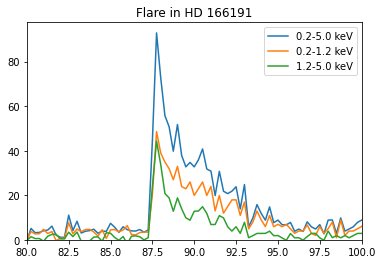

In [230]:
plt.plot(timebins[:-1] / 1000, filtered_lc_subtr(src, bkg, t0, timebins, (200, 5000), 100),label='0.2-5.0 keV')
plt.plot(timebins[:-1] / 1000, filtered_lc_subtr(src, bkg, t0, timebins, (200, 1200), 100),label='0.2-1.2 keV')
plt.plot(timebins[:-1] / 1000, filtered_lc_subtr(src, bkg, t0, timebins, (1200, 5000), 100),label='1.2-5.0 keV')

plt.legend()
plt.xlim(80, 100)
plt.ylim(0, None)
plt.title('Flare in HD 166191')

In [231]:
# Get the mean of the bins before the flare. Hard to read off by eye, but want ot compare to flare peak.
np.mean(srclc[:320])

3.96875

Text(0.5, 1.0, 'Lightcurve with Baysian blocks')

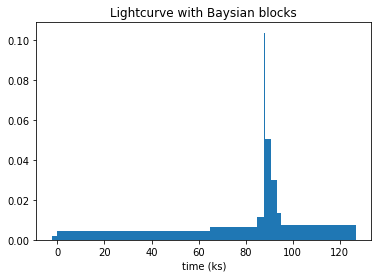

In [232]:
out = av.hist((src['TIME'] - t0)/1000, bins='blocks', density=True)
plt.xlabel('time (ks)')
plt.title('Lightcurve with Baysian blocks')

The two plots above show a lightcurve. The top one is a more traditional light curve with bins with a fixed binwidth and zoomed in to show the interesting flare. In the flare, the emission is harder (i.e. hotter), just as one would expect for a stellar flare. Just looking at the plot, the flare lasts about 7 ks and increases the count rate by a factor 20 in the peak.

The lower plot show the lightcurve with baysian blocks binning, where the bin sizes can vary and are chosen such that the break between each bin is significant. That gives a better idea on the peak of the flare (which has enough signal for a very short bin) and confirms that there is no significant variability in the quiescent phases before and after the flare.

In [237]:
srcreg = '((X,Y) IN circle(13666,22204,250))'
bkgreg = {'MOS1': '((X,Y) IN circle(14370,18000,2500))',
          'MOS2': '((X,Y) IN circle(12265,26750,2500))'}

flare_time = f'((TIME > {t0 + 87500}) && (TIME < {t0 + 95000}))'
quiet_time = f'((TIME < {t0 + 87500}) || (TIME > {t0 + 95000}))'

for det, filename in [('MOS2', '2990_0763880101_EMOS2_S002_ImagingEvts.ds'),
                      ('MOS1', '2990_0763880101_EMOS1_S001_ImagingEvts.ds')]:
    extract_spectrum(filename, 
                      f'{srcreg} && {flare_time}',
                      f'{bkgreg[det]} && {flare_time}',
                      root=f'0763880101_flare_')
    extract_spectrum(filename, 
                      f'{srcreg} && {quiet_time}',
                      f'{bkgreg[det]} && {quiet_time}',
                      root=f'0763880101_quiet_')

Executing: 
evselect table='2990_0763880101_EMOS2_S002_ImagingEvts.ds' keepfilteroutput='no' withfilteredset='no' filteredset='filtered.fits' destruct='yes' flagcolumn='EVFLAG' flagbit='-1' filtertype='expression' dssblock='' expression='#XMMEA_EM && (PATTERN<=12) && ((X,Y) IN circle(13666,22204,250)) && ((TIME > 576397717.5325445) && (TIME < 576405217.5325445))' writedss='yes' cleandss='no' updateexposure='yes' filterexposure='yes' blockstocopy='' attributestocopy='' energycolumn='PI' withzcolumn='no' zcolumn='WEIGHT' withzerrorcolumn='no' zerrorcolumn='EWEIGHT' ignorelegallimits='no' withimageset='no' imageset='image.fits' xcolumn='RAWX' ycolumn='RAWY' imagebinning='imageSize' ximagebinsize='1' yimagebinsize='1' squarepixels='no' ximagesize='600' yimagesize='600' withxranges='no' ximagemin='1' ximagemax='640' withyranges='no' yimagemin='1' yimagemax='640' withimagedatatype='no' imagedatatype='Real64' withcelestialcenter='no' raimagecenter='0' decimagecenter='0' withspectrumset='yes' 

evselect:- Executing (routine): evselect table=2990_0763880101_EMOS2_S002_ImagingEvts.ds filteredset=filtered.fits withfilteredset=no keepfilteroutput=no flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='#XMMEA_EM && (PATTERN<=12) && ((X,Y) IN circle(12265,26750,2500)) && ((TIME > 576397717.5325445) && (TIME < 576405217.5325445))' filtertype=expression cleandss=no updateexposure=yes filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PI zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 withxranges=no yimagemin=1 yimagemax=640 withyranges=no imagedatatype=Real64 withimagedatatype=no raimagecenter=0 decimagecenter=0 withcelestialcenter=no withimageset=no spectrumset=0763880101_flare_EMOS2_bg.pha spectralbinsize=5 specchannelmin=0 sp

rmfgen:- Executing (routine): rmfgen rmfset=0763880101_flare_EMOS2.rmf threshold=1e-06 withenergybins=no energymin=0 energymax=15 nenergybins=30 spectrumset=0763880101_flare_EMOS2.pha format=var detmaptype=psf detmaparray=detmapfile.ds: withdetbounds=no detxoffset=1200 detyoffset=1200 detxbins=160 detybins=160 withdetbins=yes raweventfile=rawevents.ds correctforpileup=no filterdss=yes withfilteredset=no filteredset=filteredpixellist.ds withrmfset=no psfenergy=2 withsourcepos=no sourcecoords=eqpos sourcex=0 sourcey=0 extendedsource=no modeleffarea=no modelquantumeff=no modelfiltertrans=no modelcontamination=no modelee=yes modelootcorr=no eegridfactor=100 withbadpixcorr=no badpixlocation=notSpecified setbackscale=no keeparfset=yes useodfatt=no ignoreoutoffov=yes crossreg_spectrumset='' crossregionarf=no psfmodel=notSpecified badpixelresolution=2 withbadpixres=no applyxcaladjustment=no acceptchanrange=no applyabsfluxcorr=no  -w 1 -V 4
rmfgen:- rmfgen (rmfgen-2.8.5)  [xmmsas_20211130_0941-

Making file temp_badcol.ds
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX01:RAWX and temp_badcol.ds:BADPIX01:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX02:RAWX and temp_badcol.ds:BADPIX02:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX03:RAWX and temp_badcol.ds:BADPIX03:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX04:RAWX and temp_badcol.ds:BADPIX04:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX05:RAWX and temp_badcol.ds:BADPIX05:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX06:RAWX and temp_badcol.ds:BADPIX06:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the colum

evselect:- selected 1148 rows from the input table.
evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-27T16:37:55.000
Executing: 
backscale spectrumset='0763880101_quiet_EMOS2.pha' badpixlocation='{cleanevt}' withbadpixcorr='yes' useodfatt='no' ignoreoutoffov='yes' withbadpixres='no' badpixelresolution='2' 
backscale:- Executing (routine): backscale spectrumset=0763880101_quiet_EMOS2.pha badpixlocation={cleanevt} withbadpixcorr=yes useodfatt=no ignoreoutoffov=yes badpixelresolution=2 withbadpixres=no  -w 1 -V 4
backscale:- backscale (backscale-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-27T16:37:56.000
backscale:- Executing (routine): arfgen spectrumset=0763880101_quiet_EMOS2.pha rmfset=response.ds withrmfset=no arfset=deletearf.ds detmaptype=flat detmaparray=detmapfile.ds: detxoffset=1200 detyoffset=1200 withdetbounds=no detxbins=1 detybins=1 withdetbins=yes psfenergy=2 filterdss=yes filteredset=filteredpixellist.ds withfilteredset=no sou

evselect:- selected 12203 rows from the input table.
evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-27T16:38:02.000
Executing: 
backscale spectrumset='0763880101_quiet_EMOS2_bg.pha' badpixlocation='{cleanevt}' withbadpixcorr='yes' useodfatt='no' ignoreoutoffov='yes' withbadpixres='no' badpixelresolution='2' 
backscale:- Executing (routine): backscale spectrumset=0763880101_quiet_EMOS2_bg.pha badpixlocation={cleanevt} withbadpixcorr=yes useodfatt=no ignoreoutoffov=yes badpixelresolution=2 withbadpixres=no  -w 1 -V 4
backscale:- backscale (backscale-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-27T16:38:03.000
backscale:- Executing (routine): arfgen spectrumset=0763880101_quiet_EMOS2_bg.pha rmfset=response.ds withrmfset=no arfset=deletearf.ds detmaptype=flat detmaparray=detmapfile.ds: detxoffset=1200 detyoffset=1200 withdetbounds=no detxbins=1 detybins=1 withdetbins=yes psfenergy=2 filterdss=yes filteredset=filteredpixellist.ds withfiltered

rmfgen:- Computing source position from region extent..
rmfgen:- CCF constituents accessed by the calibration server:
CifEntry{EMOS2, CONTAMINATION, 1, /nfs/mkx/a1/../d1/ccf/EMOS2_CONTAMINATION_0001.CCF, 2000-01-01T00:00:00.000}
CifEntry{EMOS2, FILTERTRANSX, 15, /nfs/mkx/a1/../d1/ccf/EMOS2_FILTERTRANSX_0015.CCF, 1998-01-01T00:00:00.000}
CifEntry{EMOS2, LINCOORD, 18, /nfs/mkx/a1/../d1/ccf/EMOS2_LINCOORD_0018.CCF, 1998-01-01T00:00:00.000}
CifEntry{EMOS2, MODEPARAM, 6, /nfs/mkx/a1/../d1/ccf/EMOS2_MODEPARAM_0006.CCF, 1999-01-01T00:00:00.000}
CifEntry{EMOS2, PATTERNLIB, 5, /nfs/mkx/a1/../d1/ccf/EMOS2_PATTERNLIB_0005.CCF, 1998-01-01T00:00:00.000}
CifEntry{EMOS2, QUANTUMEF, 21, /nfs/mkx/a1/../d1/ccf/EMOS2_QUANTUMEF_0021.CCF, 2002-11-08T00:00:01.000}
CifEntry{EMOS2, TIMECORR, 3, /nfs/mkx/a1/../d1/ccf/EMOS2_TIMECORR_0003.CCF, 1998-01-01T00:00:00.000}
CifEntry{RGS2, LINCOORD, 8, /nfs/mkx/a1/../d1/ccf/RGS2_LINCOORD_0008.CCF, 1998-01-01T00:00:00.000}
CifEntry{XMM, ABSCOEFS, 4, /nfs/mkx/a1/../d1/cc

Making file temp_badcol.ds
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX01:RAWX and temp_badcol.ds:BADPIX01:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX02:RAWX and temp_badcol.ds:BADPIX02:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX03:RAWX and temp_badcol.ds:BADPIX03:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX04:RAWX and temp_badcol.ds:BADPIX04:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX05:RAWX and temp_badcol.ds:BADPIX05:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX06:RAWX and temp_badcol.ds:BADPIX06:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the colum

evselect:- selected 518 rows from the input table.
evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-27T16:42:04.000
Executing: 
backscale spectrumset='0763880101_flare_EMOS1.pha' badpixlocation='{cleanevt}' withbadpixcorr='yes' useodfatt='no' ignoreoutoffov='yes' withbadpixres='no' badpixelresolution='2' 
backscale:- Executing (routine): backscale spectrumset=0763880101_flare_EMOS1.pha badpixlocation={cleanevt} withbadpixcorr=yes useodfatt=no ignoreoutoffov=yes badpixelresolution=2 withbadpixres=no  -w 1 -V 4
backscale:- backscale (backscale-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-27T16:42:04.000
backscale:- Executing (routine): arfgen spectrumset=0763880101_flare_EMOS1.pha rmfset=response.ds withrmfset=no arfset=deletearf.ds detmaptype=flat detmaparray=detmapfile.ds: detxoffset=1200 detyoffset=1200 withdetbounds=no detxbins=1 detybins=1 withdetbins=yes psfenergy=2 filterdss=yes filteredset=filteredpixellist.ds withfilteredset=no sour

evselect:- selected 740 rows from the input table.
evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-27T16:42:10.000
Executing: 
backscale spectrumset='0763880101_flare_EMOS1_bg.pha' badpixlocation='{cleanevt}' withbadpixcorr='yes' useodfatt='no' ignoreoutoffov='yes' withbadpixres='no' badpixelresolution='2' 
backscale:- Executing (routine): backscale spectrumset=0763880101_flare_EMOS1_bg.pha badpixlocation={cleanevt} withbadpixcorr=yes useodfatt=no ignoreoutoffov=yes badpixelresolution=2 withbadpixres=no  -w 1 -V 4
backscale:- backscale (backscale-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-27T16:42:10.000
backscale:- Executing (routine): arfgen spectrumset=0763880101_flare_EMOS1_bg.pha rmfset=response.ds withrmfset=no arfset=deletearf.ds detmaptype=flat detmaparray=detmapfile.ds: detxoffset=1200 detyoffset=1200 withdetbounds=no detxbins=1 detybins=1 withdetbins=yes psfenergy=2 filterdss=yes filteredset=filteredpixellist.ds withfilteredse

rmfgen:- Computing source position from region extent..
rmfgen:- CCF constituents accessed by the calibration server:
CifEntry{EMOS1, CONTAMINATION, 1, /nfs/mkx/a1/../d1/ccf/EMOS1_CONTAMINATION_0001.CCF, 2000-01-01T00:00:00.000}
CifEntry{EMOS1, FILTERTRANSX, 15, /nfs/mkx/a1/../d1/ccf/EMOS1_FILTERTRANSX_0015.CCF, 1998-01-01T00:00:00.000}
CifEntry{EMOS1, LINCOORD, 18, /nfs/mkx/a1/../d1/ccf/EMOS1_LINCOORD_0018.CCF, 1998-01-01T00:00:00.000}
CifEntry{EMOS1, MODEPARAM, 6, /nfs/mkx/a1/../d1/ccf/EMOS1_MODEPARAM_0006.CCF, 1998-01-01T00:00:00.000}
CifEntry{EMOS1, PATTERNLIB, 5, /nfs/mkx/a1/../d1/ccf/EMOS1_PATTERNLIB_0005.CCF, 1998-01-01T00:00:00.000}
CifEntry{EMOS1, QUANTUMEF, 21, /nfs/mkx/a1/../d1/ccf/EMOS1_QUANTUMEF_0021.CCF, 2002-11-08T00:00:01.000}
CifEntry{EMOS1, TIMECORR, 3, /nfs/mkx/a1/../d1/ccf/EMOS1_TIMECORR_0003.CCF, 1998-01-01T00:00:00.000}
CifEntry{RGS1, LINCOORD, 8, /nfs/mkx/a1/../d1/ccf/RGS1_LINCOORD_0008.CCF, 1998-01-01T00:00:00.000}
CifEntry{XMM, ABSCOEFS, 4, /nfs/mkx/a1/../d1/cc

Making file temp_badcol.ds
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX01:RAWX and temp_badcol.ds:BADPIX01:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX02:RAWX and temp_badcol.ds:BADPIX02:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX04:RAWX and temp_badcol.ds:BADPIX04:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX05:RAWX and temp_badcol.ds:BADPIX05:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX07:RAWX and temp_badcol.ds:BADPIX07:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- Writing energy data into dataset .. 
arfgen:- Calculating Area curve ...
arfgen:- Calculating Area curve ...2.499999944 2400 11997.49994
arfgen:- Executing (routine): attcalc even

evselect:- selected 1197 rows from the input table.
evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-27T16:45:40.000
Executing: 
backscale spectrumset='0763880101_quiet_EMOS1.pha' badpixlocation='{cleanevt}' withbadpixcorr='yes' useodfatt='no' ignoreoutoffov='yes' withbadpixres='no' badpixelresolution='2' 
backscale:- Executing (routine): backscale spectrumset=0763880101_quiet_EMOS1.pha badpixlocation={cleanevt} withbadpixcorr=yes useodfatt=no ignoreoutoffov=yes badpixelresolution=2 withbadpixres=no  -w 1 -V 4
backscale:- backscale (backscale-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-27T16:45:41.000
backscale:- Executing (routine): arfgen spectrumset=0763880101_quiet_EMOS1.pha rmfset=response.ds withrmfset=no arfset=deletearf.ds detmaptype=flat detmaparray=detmapfile.ds: detxoffset=1200 detyoffset=1200 withdetbounds=no detxbins=1 detybins=1 withdetbins=yes psfenergy=2 filterdss=yes filteredset=filteredpixellist.ds withfilteredset=no sou

evselect:- selected 15616 rows from the input table.
evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-27T16:45:47.000
Executing: 
backscale spectrumset='0763880101_quiet_EMOS1_bg.pha' badpixlocation='{cleanevt}' withbadpixcorr='yes' useodfatt='no' ignoreoutoffov='yes' withbadpixres='no' badpixelresolution='2' 
backscale:- Executing (routine): backscale spectrumset=0763880101_quiet_EMOS1_bg.pha badpixlocation={cleanevt} withbadpixcorr=yes useodfatt=no ignoreoutoffov=yes badpixelresolution=2 withbadpixres=no  -w 1 -V 4
backscale:- backscale (backscale-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-27T16:45:47.000
backscale:- Executing (routine): arfgen spectrumset=0763880101_quiet_EMOS1_bg.pha rmfset=response.ds withrmfset=no arfset=deletearf.ds detmaptype=flat detmaparray=detmapfile.ds: detxoffset=1200 detyoffset=1200 withdetbounds=no detxbins=1 detybins=1 withdetbins=yes psfenergy=2 filterdss=yes filteredset=filteredpixellist.ds withfiltered

rmfgen:- Computing source position from region extent..
rmfgen:- CCF constituents accessed by the calibration server:
CifEntry{EMOS1, CONTAMINATION, 1, /nfs/mkx/a1/../d1/ccf/EMOS1_CONTAMINATION_0001.CCF, 2000-01-01T00:00:00.000}
CifEntry{EMOS1, FILTERTRANSX, 15, /nfs/mkx/a1/../d1/ccf/EMOS1_FILTERTRANSX_0015.CCF, 1998-01-01T00:00:00.000}
CifEntry{EMOS1, LINCOORD, 18, /nfs/mkx/a1/../d1/ccf/EMOS1_LINCOORD_0018.CCF, 1998-01-01T00:00:00.000}
CifEntry{EMOS1, MODEPARAM, 6, /nfs/mkx/a1/../d1/ccf/EMOS1_MODEPARAM_0006.CCF, 1998-01-01T00:00:00.000}
CifEntry{EMOS1, PATTERNLIB, 5, /nfs/mkx/a1/../d1/ccf/EMOS1_PATTERNLIB_0005.CCF, 1998-01-01T00:00:00.000}
CifEntry{EMOS1, QUANTUMEF, 21, /nfs/mkx/a1/../d1/ccf/EMOS1_QUANTUMEF_0021.CCF, 2002-11-08T00:00:01.000}
CifEntry{EMOS1, TIMECORR, 3, /nfs/mkx/a1/../d1/ccf/EMOS1_TIMECORR_0003.CCF, 1998-01-01T00:00:00.000}
CifEntry{RGS1, LINCOORD, 8, /nfs/mkx/a1/../d1/ccf/RGS1_LINCOORD_0008.CCF, 1998-01-01T00:00:00.000}
CifEntry{XMM, ABSCOEFS, 4, /nfs/mkx/a1/../d1/cc

Making file temp_badcol.ds
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX01:RAWX and temp_badcol.ds:BADPIX01:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX02:RAWX and temp_badcol.ds:BADPIX02:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX04:RAWX and temp_badcol.ds:BADPIX04:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX05:RAWX and temp_badcol.ds:BADPIX05:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- WCS info for the columns temp_badcol.ds:BADPIX07:RAWX and temp_badcol.ds:BADPIX07:RAWX is either non-existent or incomplete. Assuming a 1:1 mapping
arfgen:- Writing energy data into dataset .. 
arfgen:- Calculating Area curve ...
arfgen:- Calculating Area curve ...2.499999944 2400 11997.49994
arfgen:- Executing (routine): attcalc even

## ObsID 0201270101

In [131]:
workdir = '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101'

In [137]:
os.makedirs(workdir, exist_ok=True)

In [142]:
w('startsas', ['odfid=0201270101', f'workdir={workdir}']).run()

startsas - WARNING - Executing /nfs/mkx/a1/linux-x86_64/opt/packages/xmmsas_20211130_0941/lib/python/pysas/startsas/startsas.py {'odfid': '0201270101', 'workdir': '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101', 'sasfiles': 'no', 'sas_ccf': '', 'sas_odf': '', 'level': 'ODF', 'cifbuild_opts': '', 'odfingest_opts': ''}




        Starting SAS session
    
        Working directory = /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101
    
        
Requesting odfid  = 0201270101 to XMM-Newton Science Archive



INFO: Copying file to 0201270101.tar.gz... [astroquery.esa.xmm_newton.core]

Creating directory 0201270101 ...

Unpacking 0201270101.tar.gz ...

Unpacking 0882_0201270101.TAR ...

Setting SAS_ODF = /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101/0201270101

Running cifbuild...

Setting SAS_CCF = /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101/ccf.cif

Running odfingest...

Setting SAS_ODF = /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101/0882_0201270101_SCX00000SUM.SAS




        SAS_CCF = /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101/ccf.cif
        SAS_ODF = /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101/0882_0201270101_SCX00000SUM.SAS
        



In [145]:
workdir

'/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101'

In [ ]:
# When I rerun this notebook, I don't have to download the data again, and run the time-consuming
# odfigest again, instead I can just point to existing CCF and SAS file. 
# Written like this, the command just sets the SAS_CCF and SAS_ODF environment variable.
w('startsas', ['sas_ccf=ccf.cif', 'sas_odf=0882_0201270101_SCX00000SUM.SAS', f'workdir={workdir}']).run()

In [146]:
os.chdir(workdir)

In [147]:
w('epproc', []).run()
w('emproc', []).run()

Executing: 
epproc withdefaultcal='yes' removetemporaries='yes' removeintermediategtis='yes' removeintermediateeventlists='yes' pileuptempfile='no' selectccds='no' ccd1='no' ccd2='no' ccd3='no' ccd4='no' ccd5='no' ccd6='no' ccd7='no' ccd8='no' ccd9='no' ccd10='no' ccd11='no' ccd12='no' selectmodes='yes' imaging='yes' timing='yes' burst='no' timingsrcposition='190' withinstexpids='no' instexpids='' withgtiset='no' gtiset='gti.ds' runhkgtigen='yes' runatthkgen='yes' referencepointing='median' ra='0' dec='0' posangle='0' filterevents='yes' filterexpression='(PI > 150 && RAWY > 0)' flagfilteredevents='no' rungtimerge='no' applygti='yes' runevlistcomb='yes' othertables='EXPOSURE BADPIX STDGTI DLIMAP HKAUX' runepexposure='yes' randomizetime='yes' spatialexposure='yes' deleteexposurecolumns='yes' searchforbadpixels='yes' searchforbadcolumns='yes' thresholdlabel='rate' lothresh='0' hithresh='0.0045' columnsearchlabel='median' locolthresh='0' hicolthresh='0.00105' flickertimesteps='1' flickerks

epproc::epframes:- Offset map before current exposure PNS003 and CCD: 4  was found: 0882_0201270101_PNU10104ODI.FIT
epproc::epframes:- The following Offset data for exposure PNS003 and CCD: 4  was found: 0882_0201270101_PNU10104ODI.FIT
epproc::epframes:- Offset map before current exposure PNS003 and CCD: 4  was found: 0882_0201270101_PNU10104ODI.FIT
epproc::epframes:- The following Offset data for exposure PNS003 and CCD: 4  was found: 0882_0201270101_PNU10104ODI.FIT
epproc::epframes:-  CAL_JUMP_TOLERANCE =    30     [units]
epproc::epframes:-  
** epproc::epframes: warning (InvalidObtValue), OBT vector element #32566 is invalid (-100)
epproc::epframes:-  Reset F1030: Time_o  Time_n  Length =    134328263   134328553         290
epproc::epframes:-  Reset F1030: Time_o  Time_n  Length =    134328553   134360953       32400
epproc::epframes:-  Reset F1030: Time_o  Time_n  Length =    134360953   134393353       32400
epproc::epframes:-  Number of F1030 resets:           3
epproc::epframe

epproc::badpixfind:-  
epproc::badpixfind:-   *** Badpixfind Mode1 *** - Searching for hot/dead columns
epproc::badpixfind:-  
epproc::badpixfind:-   *** Badpixfind Mode1 *** - Searching for hot/dead pixels
epproc::badpixfind:- No hot or dead pixels found - thresholds OK?
epproc::badpixfind:-   
epproc::badpixfind:-   *** Checking final badpixfind list ***
epproc::badpixfind:-  Creating file (.//0882_0201270101_EPN_S003_04_Badpixels.ds): Number of entries:            0
epproc::badpixfind:- badpixfind (badpixfind-1.41)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:27:46.000
epproc:- badpixfind (badpixfind-1.41)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:27:46.000
epproc:- Executing (invoked): badpix eventset=.//0882_0201270101_EPN_S003_04_EvtsFramesTemp.ds getuplnkbadpix=yes getotherbadpix=yes badpixset=.//0882_0201270101_EPN_S003_04_Badpixels.ds getnewbadpix=yes emptyextension=no windowfilter=no outset=out.fits withoutset=no  -w 1 -V 4
epproc:- badpix (badpix-2.33)

epproc::attcalc:-  Column X does not exist - creating
epproc::attcalc:-  Column Y does not exist - creating
epproc::attcalc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:29:11.000
epproc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:29:11.000
epproc:- Executing (invoked): dsrename newname=EXPOSU04 object=.//0882_0201270101_EPN_S003_04_Evts.ds:EXPOSURE  -w 1 -V 4
epproc:- dsrename (daltools-1.11.1)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:29:11.000
epproc::dsrename:- Executing (routine): dsrename newname=EXPOSU04 object=.//0882_0201270101_EPN_S003_04_Evts.ds:EXPOSURE  -w 1 -V 4
epproc::dsrename:- dsrename (daltools-1.11.1)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:29:11.000
epproc::dsrename:- dsrename (daltools-1.11.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:29:11.000
epproc:- dsrename (daltools-1.11.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:29:11.000
epproc:- Ex

epproc::evlistcomb:-  Writing extension EXPOSU04 from .//0882_0201270101_EPN_S003_04_Evts.ds:EXPOSU04
epproc::evlistcomb:-  Writing extension BADPIX04 from .//0882_0201270101_EPN_S003_04_Evts.ds:BADPIX
epproc::evlistcomb:-  extension STDGTI not found in .//0882_0201270101_EPN_S003_04_Evts.ds
epproc::evlistcomb:-  Writing extension DLIMAP04 from .//0882_0201270101_EPN_S003_04_Evts.ds:DLIMAP
epproc::evlistcomb:-  Writing extension HKAUX04 from .//0882_0201270101_EPN_S003_04_Evts.ds:HKAUX
epproc::evlistcomb:-  Entering mode TIMING
epproc::evlistcomb:-  No output for mode TIMING
epproc::evlistcomb:- evlistcomb (evlistcomb-4.20)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:29:18.000
epproc:- evlistcomb (evlistcomb-4.20)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:29:18.000
epproc:- Executing (invoked): dscopyblock blocks=/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101/ccf.cif:CALINDEX to=.//0882_0201270101_EPN_S003_ImagingEvts.ds  -w 1 -V 4
epproc:- ds

emproc:- 0 [Imaging] -> 1
emproc:- 2 [ReducedImaging] -> 0
emproc:- 1 [Timing] -> 0
emproc:- Considering one of the 1 exposures for mode 0 [Imaging]
emproc:- Considering exposure M1S001[index=0]
emproc:- Considering one of the 0 exposures for mode 2 [ReducedImaging]
emproc:- Considering one of the 0 exposures for mode 1 [Timing]
emproc:- Selected exposure: 1 mode 0 [Imaging]
emproc:- .//0882_0201270101_AttHk.ds exists. atthkgen will not be run again.
emproc:- Executing (invoked): hkgtigen instrument=emos1 gtiset=.//0882_0201270101_EMOS1_HkGti.ds diagfile=STDOUT plotgtis=no diagnosticmode=no withgtiset=yes parameters='' withparameters=no except=no overrideparameters='' overrideparametervalues='' withoverrideparameters=no timecolumn=TIME prefraction=0.5 postfraction=0.5  -w 1 -V 4
emproc:- hkgtigen (hkgtigen-1.15)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:29:26.000
emproc::hkgtigen:- Executing (routine): hkgtigen instrument=emos1 gtiset=.//0882_0201270101_EMOS1_HkGti.ds diag

emproc::emenergy:-       321554  events in file
emproc::emenergy:- EVFLAG will be applied
emproc::emenergy:-  Bad offsets will be taken from the OFFSETS extension.
emproc::emenergy:- Energies will be corrected using E4 information
emproc::emenergy:-  Events with ENERGYE1 >=         100  will be used to build the background map.
emproc::emenergy:-  Events with PERIPIX <=           0  will be used to build the background map.
emproc::emenergy:-  Background data will be filled by row and column averaging when less than           10  events around.
emproc::emenergy:-  no BADPIX extension in input event file. Assume no bad pixel in EVFLAG.
emproc::emenergy:-        11656  events outside field of view
emproc::emenergy:-        73820  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-         1803  events rejected by   3.00000000      sigma clipping on E4 for CCDBKG
emproc::emenergy:-        74034  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-        11551  events w

emproc::emframes:-  Event file .//0882_0201270101_EMOS1_S001_02_EvtsFramesTemp.ds modified
emproc::emframes:-           65  missing frames in FRAMES
emproc::emframes:-            4  extended frames in FRAMES
emproc::emframes:-  Create .//0882_0201270101_EMOS1_S001_02_FramesTemp.ds with       26716  rows
emproc::emframes:-  Observing mode was PrimeFullWindow
emproc::emframes:-  Approximate start time =   213090040.75709343
emproc::emframes:-  Approximate   end time =   213159511.06022999
emproc::emframes:-            0  frames rejected by VALID
emproc::emframes:-            0  frames rejected by FIFO
emproc::emframes:-  Area of window within field of view is   76.9555511      arcmin2
emproc::emframes:-  Fraction of window within field of view is  0.635072231
emproc::emframes:-            0  frames rejected by FLAG_HK
emproc::emframes:-  Fraction of good time :   0.98967744022828164
emproc::emframes:-  Writing extension STDGTI02
emproc::emframes:-  Create .//0882_0201270101_EMOS1_S001_02

** emproc::evselect: warning (NoCCDcolumn), Event list does not have a CCDNR column. Cannot update exposure information. 
emproc::evselect:- selected 107125 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:29:35.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:29:35.000
emproc:- Executing (invoked): emeventsproj eventset=.//0882_0201270101_EMOS1_S001_02_EvtsForBadpixfindTemp.ds evimageset=.//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:29:35.000
emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//0882_0201270101_EMOS1_S001_02_EvtsForBadpixfindTemp.ds evimageset=.//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedev

emproc::emevents:-            0  events below the EMDH lower threshold
emproc::emevents:-            0  events above the EMDH upper threshold
emproc::emevents:-       178865  events in output
emproc::emevents:-           30  events outside good frames
emproc::emevents:-        49548  cosmic-ray events
emproc::emevents:-         1603  events outside window
emproc::emevents:-  maximum number of expected events per row  0.29602942280267208
emproc::emevents:-           30  events in rows with more than           4  events above expected.
emproc::emevents:-            0  flagged events next to bad rows
emproc::emevents:-            0  events on row/column with wrong offset
emproc::emevents:-          176  events with E3 <         -40  + local median
emproc::emevents:-  maximum number of expected events per bin   1.14775491
emproc::emevents:-           11  events detected as flickering at tolerances           5           2           2
emproc::emevents:-        17726  events with truncated E1

emproc::embadpixfind:- Executing (routine): embadpixfind evimageset=.//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds badpixset=.//0882_0201270101_EMOS1_S001_03_Badpixels.ds incremental=no halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=yes niter=10 includedeadpixels=yes ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:29:40.000
emproc::embadpixfind:-  Opening image file : .//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds
emproc::embadpixfind:-  Half width for 2D searches:           2
emproc::embadpixfind:-  False detection probability:   9.99999997E-07  per pixel
emproc::embadpixfind:- The task will also look for bad segments in rows or columns
emproc::embadpixfind:-  Half width for 1D searches:           3
emproc::embadpixfind:- The task will look for bright pixels
emproc::embadpixfind:-  The task 

emproc::emevents:-           75  events detected as flickering at tolerances           5           2           2
emproc::emevents:-        14756  events with truncated E1
emproc::emevents:-  Fraction of good events :   0.621412933
emproc::emevents:- emevents (emevents-8.8)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:29:43.000
emproc:- emevents (emevents-8.8)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:29:43.000
emproc:- Executing (invoked): emenergy ineventset=.//0882_0201270101_EMOS1_S001_04_EvtsForBadpixfindTemp.ds outeventset=events.out newoutput=no flagevents=yes correctcti=no minenergy=100 maxperipix=0 fillminnumber=10 fillccdbkg=yes backgroundset=bkgccd.map timebin=100 writebackgroundset=no getccdbkg=yes useccfdarkframe=no maskedccdset='' withmaskedccdset=no rejectbade3e4=yes randomizeenergy=no makepha=yes correctgain=no ontimepha=no  -w 1 -V 4
emproc:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:29:43.000
emproc::emenergy:

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-           24  bright pixels found in image
emproc::embadpixfind:-            0  dark and           3  bright columns found in image
emproc::embadpixfind:-            0  dark and           1  bright rows found in image
emproc::embadpixfind:-            1  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            1  bright pixels found in image
emproc::embadpixfind:-            0  dark and           1  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           3
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-   

emproc::emenergy:-  no BADPIX extension in input event file. Assume no bad pixel in EVFLAG.
emproc::emenergy:-        28363  events outside field of view
emproc::emenergy:-        13967  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-          273  events rejected by   3.00000000      sigma clipping on E4 for CCDBKG
emproc::emenergy:-        14115  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-         6677  events with PHA out of range          25  -        4095
emproc::emenergy:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:29:48.000
emproc:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:29:48.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS1_S001_05_EvtsForBadpixfindTemp.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleands

emproc::emframes:-  Event file .//0882_0201270101_EMOS1_S001_06_EvtsFramesTemp.ds modified
emproc::emframes:-           63  missing frames in FRAMES
emproc::emframes:-           19  extended frames in FRAMES
emproc::emframes:-  Create .//0882_0201270101_EMOS1_S001_06_FramesTemp.ds with       26701  rows
emproc::emframes:-  Observing mode was PrimeFullWindow
emproc::emframes:-  Approximate start time =   213090040.77544898
emproc::emframes:-  Approximate   end time =   213159511.07858554
emproc::emframes:-            0  frames rejected by VALID
emproc::emframes:-            0  frames rejected by FIFO
emproc::emframes:-  Area of window within field of view is   91.2445679      arcmin2
emproc::emframes:-  Fraction of window within field of view is  0.752991676
emproc::emframes:-            0  frames rejected by FLAG_HK
emproc::emframes:-  Fraction of good time :   0.98953839880823680
emproc::emframes:-  Writing extension STDGTI06
emproc::emframes:-  Create .//0882_0201270101_EMOS1_S001_06

** emproc::evselect: warning (NoCCDcolumn), Event list does not have a CCDNR column. Cannot update exposure information. 
emproc::evselect:- selected 121340 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:29:53.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:29:53.000
emproc:- Executing (invoked): emeventsproj eventset=.//0882_0201270101_EMOS1_S001_06_EvtsForBadpixfindTemp.ds evimageset=.//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:29:53.000
emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//0882_0201270101_EMOS1_S001_06_EvtsForBadpixfindTemp.ds evimageset=.//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedev

emproc::emevents:-            0  events below the EMDH lower threshold
emproc::emevents:-            0  events above the EMDH upper threshold
emproc::emevents:-       181348  events in output
emproc::emevents:-           39  events outside good frames
emproc::emevents:-        54663  cosmic-ray events
emproc::emevents:-         1733  events outside window
emproc::emevents:-  maximum number of expected events per row  0.22510318949343339
emproc::emevents:-         8541  events in rows with more than           4  events above expected.
emproc::emevents:-           80  flagged events next to bad rows
emproc::emevents:-            0  events on row/column with wrong offset
emproc::emevents:-         3605  events with E3 <         -51  + local median
emproc::emevents:-  maximum number of expected events per bin  0.860501289
emproc::emevents:-          160  events detected as flickering at tolerances           5           2           2
emproc::emevents:-        16923  events with truncated E1

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-           11  bright pixels found in image
emproc::embadpixfind:-            0  dark and           2  bright columns found in image
emproc::embadpixfind:-            0  dark and           2  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:-  Writing         582  rows to .//0882_0201270101_EMOS1_S001_07_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:29:59.000
emproc:- embadpixfind 

emproc::evlistcomb:-  Writing extension EXPOSU07 from .//0882_0201270101_EMOS1_S001_07_EvtsForBadpixfindTemp.ds:EXPOSURE
emproc::evlistcomb:-  extension BADPIX not found in .//0882_0201270101_EMOS1_S001_07_EvtsForBadpixfindTemp.ds
emproc::evlistcomb:-  extension STDGTI not found in .//0882_0201270101_EMOS1_S001_07_EvtsForBadpixfindTemp.ds
emproc::evlistcomb:-  Entering mode TIMING
emproc::evlistcomb:-  No output for mode TIMING
emproc::evlistcomb:- evlistcomb (evlistcomb-4.20)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:00.000
emproc:- evlistcomb (evlistcomb-4.20)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:00.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS1_S001_merged.img.ds filteredset=.//0882_0201270101_EMOS1_S001_MIEVLI0000.ds withfilteredset=yes keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='((FLAG & 0x762aa000) == 0)' filtertype=expression cleandss=yes updateexposure=yes filterexposure=y

emproc::evselect:- selected 76147 rows from the input table.
** emproc::evselect: warning (NoProductExp), No live time information available.  Cannot write EXPOSURE keyword for output products.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:04.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:04.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS1_S001_MIEVLI0000.ds filteredset=filtered.fits withfilteredset=no keepfilteroutput=no flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression=true filtertype=expression cleandss=no updateexposure=yes filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=ima

emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:05.000
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:05.000
emproc:- Executing (invoked): embadpixfind evimageset=.//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds badpixset=.//0882_0201270101_EMOS1_S001_01_Badpixels.ds incremental=yes halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=no niter=10 includedeadpixels=no ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:30:05.000
emproc::embadpixfind:- Executing (routine): embadpixfind evimageset=.//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds badpixset=.//0882_0201270101_EMOS1_S001_01_Badpixels.ds incremental=yes halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            4  bright pixels found in image
emproc::embadpixfind:-            0  dark and           1  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:-  Writing         426  rows to .//0882_0201270101_EMOS1_S001_01_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:07.000
emproc:- embadpixfind 

emproc::attcalc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:26.000
emproc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:26.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS1_S001_01_Evts.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 withxranges=no yimagemin=1 yimagemax=640 withyranges=no imagedatatype=Real64 withimagedatatype=no raimagecenter=0 decimagecenter=0 withcelestial

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-  Writing         673  rows to .//0882_0201270101_EMOS1_S001_02_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:28.000
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:28.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS1_S001_MIEVLI0000.ds filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='PHA < 150' filtertype=expression cleandss=no updateexposure=yes filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' 

emproc::badpix:- Note - Not all exact CCF entries contained within Badpixfind file 
emproc::badpix:-  Note -            3  of          673  badpixfind entries in CCF: purging extension
emproc::badpix:-          675  final bad pixel sets will be added to BADPIX extension
emproc::badpix:- badpix (badpix-2.33)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:29.000
emproc:- badpix (badpix-2.33)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:29.000
emproc:- Executing (invoked): emevents odfeventset=.//0882_0201270101_EMOS1_S001_02_EvtsFramesTemp.ds eventset=.//0882_0201270101_EMOS1_S001_02_Evts.ds newoutput=yes frameset=.//0882_0201270101_EMOS1_S001_02_FramesTemp.ds flagbadtimes=yes gattispecset=gattispec.out writegattispecset=no flagtruncatede1=yes othereventset='' otherframeset='' withothernode=no withframeset=yes offvarsets='' withoffvarsets=no analysepatterns=yes flagbadpixels=yes keepsifluor=no splitdiagonals=yes randomizeposition=yes setcoordinates=yes maxeventspe

emproc::evselect:- selected 104148 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:42.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:42.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS1_S001_03_EvtsForBadpixfindTemp.ds filteredset=.//0882_0201270101_EMOS1_S001_MIEVLI0000.ds withfilteredset=yes keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='GTI(.//0882_0201270101_EMOS1_S001_FBKGTI0000.ds,TIME)' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 wit

emproc::evselect:- selected 10644 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:43.000
** emproc::evselect: warning (SummaryOfWarnings), 
   warning NoCCDcolumn silently occurred 1 times
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:43.000
emproc:- Executing (invoked): emeventsproj eventset=.//0882_0201270101_EMOS1_S001_MIEVLI0000.ds evimageset=.//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:30:43.000
emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//0882_0201270101_EMOS1_S001_MIEVLI0000.ds evimageset=.//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc::emeventsproj:- emeven

emproc::emevents:-           15  events detected as flickering at tolerances           5           2           2
emproc::emevents:-        17726  events with truncated E1
emproc::emevents:-  Fraction of good events :   0.541743755
emproc::emevents:- emevents (emevents-8.8)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:46.000
emproc:- emevents (emevents-8.8)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:46.000
emproc:- Executing (invoked): emenergy ineventset=.//0882_0201270101_EMOS1_S001_03_Evts.ds outeventset=events.out newoutput=no flagevents=yes correctcti=yes minenergy=100 maxperipix=0 fillminnumber=10 fillccdbkg=yes backgroundset=bkgccd.map timebin=100 writebackgroundset=no getccdbkg=yes useccfdarkframe=no maskedccdset='' withmaskedccdset=no rejectbade3e4=yes randomizeenergy=yes makepha=yes correctgain=yes ontimepha=no  -w 1 -V 4
emproc:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:30:46.000
emproc::emenergy:- Executing (r

emproc::evselect:- selected 44480 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:57.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:57.000
emproc:- Executing (invoked): emeventsproj eventset=.//0882_0201270101_EMOS1_S001_MIEVLI0000.ds evimageset=.//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:30:57.000
emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//0882_0201270101_EMOS1_S001_MIEVLI0000.ds evimageset=.//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:30:57.000
emproc::e

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            6  bright pixels found in image
emproc::embadpixfind:-            0  dark and           2  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:-  Writing         596  rows to .//0882_0201270101_EMOS1_S001_04_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:30:58.000
emproc:- embadpixfind 

emproc::attcalc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:13.000
emproc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:13.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS1_S001_04_Evts.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 withxranges=no yimagemin=1 yimagemax=640 withyranges=no imagedatatype=Real64 withimagedatatype=no raimagecenter=0 decimagecenter=0 withcelestial

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-  Writing         633  rows to .//0882_0201270101_EMOS1_S001_05_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:15.000
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:15.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS1_S001_MIEVLI0000.ds filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='PHA < 150' filtertype=expression cleandss=no updateexposure=yes filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' 

emproc::badpix:- Note - Not all exact CCF entries contained within Badpixfind file 
emproc::badpix:-  Note -            6  of          634  badpixfind entries in CCF: purging extension
emproc::badpix:-          638  final bad pixel sets will be added to BADPIX extension
emproc::badpix:- badpix (badpix-2.33)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:16.000
emproc:- badpix (badpix-2.33)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:16.000
emproc:- Executing (invoked): emevents odfeventset=.//0882_0201270101_EMOS1_S001_05_EvtsFramesTemp.ds eventset=.//0882_0201270101_EMOS1_S001_05_Evts.ds newoutput=yes frameset=.//0882_0201270101_EMOS1_S001_05_FramesTemp.ds flagbadtimes=yes gattispecset=gattispec.out writegattispecset=no flagtruncatede1=yes othereventset='' otherframeset='' withothernode=no withframeset=yes offvarsets='' withoffvarsets=no analysepatterns=yes flagbadpixels=yes keepsifluor=no splitdiagonals=yes randomizeposition=yes setcoordinates=yes maxeventspe

emproc::evselect:- selected 97921 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:27.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:27.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS1_S001_06_EvtsForBadpixfindTemp.ds filteredset=.//0882_0201270101_EMOS1_S001_MIEVLI0000.ds withfilteredset=yes keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='GTI(.//0882_0201270101_EMOS1_S001_FBKGTI0000.ds,TIME)' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 with

emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//0882_0201270101_EMOS1_S001_MIEVLI0000.ds evimageset=.//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:31:29.000
emproc::emeventsproj:-  Opening input event file : .//0882_0201270101_EMOS1_S001_MIEVLI0000.ds
emproc::emeventsproj:- The counts will be projected.
emproc::emeventsproj:- Events flagged for rejection will not be projected.
emproc::emeventsproj:-  Opening output image file : .//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds
emproc::emeventsproj:-  Number of good events in input file:         6261
emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:29.000
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:29

emproc::emenergy:-  Found         631  bad pixels in .//0882_0201270101_EMOS1_S001_06_Evts.ds:BADPIX
emproc::emenergy:-        18339  events outside field of view
emproc::emenergy:-        18174  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-          318  events rejected by   3.00000000      sigma clipping on E4 for CCDBKG
emproc::emenergy:-        18751  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-         8093  events with PHA out of range          25  -        4095
emproc::emenergy:-         8251  events with PI out of range           75  -        14037
emproc::emenergy:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:33.000
emproc:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:34.000
emproc:- Executing (invoked): attcalc eventset=.//0882_0201270101_EMOS1_S001_06_Evts.ds fixedra=0 fixeddec=0 fixedposangle=0 attitudelabel=ahf nominalra=0 nominaldec=0 setpnttouser=no refpointlabel=

emproc::emeventsproj:- The counts will be projected.
emproc::emeventsproj:- Events flagged for rejection will not be projected.
emproc::emeventsproj:-  Opening output image file : .//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds
emproc::emeventsproj:-  Number of good events in input file:        45725
emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:44.000
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:44.000
emproc:- Executing (invoked): embadpixfind evimageset=.//0882_0201270101_EMOS1_S001_EvtsForEmeventsprojTemp.ds badpixset=.//0882_0201270101_EMOS1_S001_07_Badpixels.ds incremental=yes halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=no niter=10 includedeadpixels=no ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] started:  202

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           2  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:-  Writing         583  rows to .//0882_0201270101_EMOS1_S001_07_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:45.000
emproc:- embadpixfind 

emproc::attcalc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:58.000
emproc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:31:58.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS1_S001_07_Evts.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 withxranges=no yimagemin=1 yimagemax=640 withyranges=no imagedatatype=Real64 withimagedatatype=no raimagecenter=0 decimagecenter=0 withcelestial

emproc::evlistcomb:-  .//0882_0201270101_EMOS1_S001_ImagingEvts.ds:EVENTS has      773902  rows
emproc::evlistcomb:-  .//0882_0201270101_EMOS1_S001_ImagingEvts.ds:OFFSETS has          56  rows
emproc::evlistcomb:-  Writing extension EXPOSU01 from .//0882_0201270101_EMOS1_S001_01_Evts.ds:EXPOSURE
emproc::evlistcomb:-  Writing extension BADPIX01 from .//0882_0201270101_EMOS1_S001_01_Evts.ds:BADPIX
emproc::evlistcomb:-  extension STDGTI not found in .//0882_0201270101_EMOS1_S001_01_Evts.ds
emproc::evlistcomb:-  Writing extension EXPOSU02 from .//0882_0201270101_EMOS1_S001_02_Evts.ds:EXPOSURE
emproc::evlistcomb:-  Writing extension BADPIX02 from .//0882_0201270101_EMOS1_S001_02_Evts.ds:BADPIX
emproc::evlistcomb:-  extension STDGTI not found in .//0882_0201270101_EMOS1_S001_02_Evts.ds
emproc::evlistcomb:-  Writing extension EXPOSU03 from .//0882_0201270101_EMOS1_S001_03_Evts.ds:EXPOSURE
emproc::evlistcomb:-  Writing extension BADPIX03 from .//0882_0201270101_EMOS1_S001_03_Evts.ds:BADPIX
emp

emproc::hkgtigen:- hkgtigen (hkgtigen-1.15)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:02.000
emproc:- hkgtigen (hkgtigen-1.15)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:02.000
emproc:- Processing S002
emproc:- Processing data set: /melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101/0201270101/0882_0201270101_M2S00210IME.FIT
emproc:- Executing (invoked): emframes auxiliaryset=/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101/0201270101/0882_0201270101_M2S00200AUX.FIT frameset=.//0882_0201270101_EMOS2_S002_01_FramesTemp.ds newframeset=yes countingset='' withcountingset=no srcra=0 srcdec=0 withsrccoords=no checkframes=yes ingtiset=.//0882_0201270101_EMOS2_HkGti.ds flagbadtimes=yes flagfifooverflow=yes outgtiset=.//0882_0201270101_EMOS2_S002_01_FrmGti.ds writegtiset=yes setgatti=yes odfeventset=/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101/0201270101/0882_0201270101_M2S00210IME.FIT outeventset=.//0882_0201270

emproc::emenergy:-        20485  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-         1611  events rejected by   3.00000000      sigma clipping on E4 for CCDBKG
emproc::emenergy:-        20341  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-         9207  events with PHA out of range          25  -        4095
emproc::emenergy:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:07.000
emproc:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:07.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS2_S002_01_EvtsForBadpixfindTemp.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerror

emproc::emframes:- Executing (routine): emframes auxiliaryset=/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101/0201270101/0882_0201270101_M2S00200AUX.FIT frameset=.//0882_0201270101_EMOS2_S002_02_FramesTemp.ds newframeset=yes countingset='' withcountingset=no srcra=0 srcdec=0 withsrccoords=no checkframes=yes ingtiset=.//0882_0201270101_EMOS2_HkGti.ds flagbadtimes=yes flagfifooverflow=yes outgtiset=.//0882_0201270101_EMOS2_S002_02_FrmGti.ds writegtiset=yes setgatti=yes odfeventset=/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101/0201270101/0882_0201270101_M2S00220IME.FIT outeventset=.//0882_0201270101_EMOS2_S002_02_EvtsFramesTemp.ds neweventset=yes checknvalid=yes setdeadtime=yes withodfeventset=yes  -w 1 -V 4
emproc::emframes:- emframes (emframes-5.11)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:32:08.000
emproc::emframes:-  Event file .//0882_0201270101_EMOS2_S002_02_EvtsFramesTemp.ds modified
emproc::emframes:-           60  missing frames

** emproc::evselect: warning (NoCCDcolumn), Event list does not have a CCDNR column. Cannot update exposure information. 
emproc::evselect:- selected 87675 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:12.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:12.000
emproc:- Executing (invoked): emeventsproj eventset=.//0882_0201270101_EMOS2_S002_02_EvtsForBadpixfindTemp.ds evimageset=.//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:32:12.000
emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//0882_0201270101_EMOS2_S002_02_EvtsForBadpixfindTemp.ds evimageset=.//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeve

emproc::emevents:-            0  events below the EMDH lower threshold
emproc::emevents:-            0  events above the EMDH upper threshold
emproc::emevents:-       169868  events in output
emproc::emevents:-           16  events outside good frames
emproc::emevents:-        49184  cosmic-ray events
emproc::emevents:-         1692  events outside window
emproc::emevents:-  maximum number of expected events per row   4.6353638854483355E-002
emproc::emevents:-          113  events in rows with more than           4  events above expected.
emproc::emevents:-           24  flagged events next to bad rows
emproc::emevents:-            0  events on row/column with wrong offset
emproc::emevents:-          917  events with E3 <         -30  + local median
emproc::emevents:-  maximum number of expected events per bin   4.60758917E-02
emproc::emevents:-          105  events detected as flickering at tolerances           5           2           2
emproc::emevents:-        14615  events with tru

emproc::embadpixfind:- Dead pixels from the CAL will be included in the bad pixels list
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-           11  bright pixels found in image
emproc::embadpixfind:-            0  dark and           2  bright columns found in image
emproc::embadpixfind:-            0  dark and           2  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:-  Writing         612  rows to .//0882_0201270101_EMOS2_S002_03_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)

emproc::emenergy:-  no BADPIX extension in input event file. Assume no bad pixel in EVFLAG.
emproc::emenergy:-        33224  events outside field of view
emproc::emenergy:-        12432  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-          557  events rejected by   3.00000000      sigma clipping on E4 for CCDBKG
emproc::emenergy:-        12834  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-         5577  events with PHA out of range          25  -        4095
emproc::emenergy:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:20.000
emproc:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:20.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS2_S002_04_EvtsForBadpixfindTemp.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleands

emproc::emframes:- Executing (routine): emframes auxiliaryset=/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101/0201270101/0882_0201270101_M2S00200AUX.FIT frameset=.//0882_0201270101_EMOS2_S002_05_FramesTemp.ds newframeset=yes countingset='' withcountingset=no srcra=0 srcdec=0 withsrccoords=no checkframes=yes ingtiset=.//0882_0201270101_EMOS2_HkGti.ds flagbadtimes=yes flagfifooverflow=yes outgtiset=.//0882_0201270101_EMOS2_S002_05_FrmGti.ds writegtiset=yes setgatti=yes odfeventset=/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101/0201270101/0882_0201270101_M2S00250IME.FIT outeventset=.//0882_0201270101_EMOS2_S002_05_EvtsFramesTemp.ds neweventset=yes checknvalid=yes setdeadtime=yes withodfeventset=yes  -w 1 -V 4
emproc::emframes:- emframes (emframes-5.11)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:32:21.000
emproc::emframes:-  Event file .//0882_0201270101_EMOS2_S002_05_EvtsFramesTemp.ds modified
emproc::emframes:-           66  missing frames

** emproc::evselect: warning (NoCCDcolumn), Event list does not have a CCDNR column. Cannot update exposure information. 
emproc::evselect:- selected 125694 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:25.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:25.000
emproc:- Executing (invoked): emeventsproj eventset=.//0882_0201270101_EMOS2_S002_05_EvtsForBadpixfindTemp.ds evimageset=.//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:32:25.000
emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//0882_0201270101_EMOS2_S002_05_EvtsForBadpixfindTemp.ds evimageset=.//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedev

emproc::emevents:-            0  events below the EMDH lower threshold
emproc::emevents:-            0  events above the EMDH upper threshold
emproc::emevents:-       169202  events in output
emproc::emevents:-           27  events outside good frames
emproc::emevents:-        47411  cosmic-ray events
emproc::emevents:-         1461  events outside window
emproc::emevents:-  maximum number of expected events per row  0.10313379620942015
emproc::emevents:-            0  events in rows with more than           4  events above expected.
emproc::emevents:-            0  flagged events next to bad rows
emproc::emevents:-            0  events on row/column with wrong offset
emproc::emevents:-           74  events with E3 <         -36  + local median
emproc::emevents:-  maximum number of expected events per bin  0.377793968
emproc::emevents:-         3378  events detected as flickering at tolerances           5           2           2
emproc::emevents:-        16393  events with truncated E1

emproc::embadpixfind:- Executing (routine): embadpixfind evimageset=.//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds badpixset=.//0882_0201270101_EMOS2_S002_06_Badpixels.ds incremental=no halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=yes niter=10 includedeadpixels=yes ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:32:29.000
emproc::embadpixfind:-  Opening image file : .//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds
emproc::embadpixfind:-  Half width for 2D searches:           2
emproc::embadpixfind:-  False detection probability:   9.99999997E-07  per pixel
emproc::embadpixfind:- The task will also look for bad segments in rows or columns
emproc::embadpixfind:-  Half width for 1D searches:           3
emproc::embadpixfind:- The task will look for bright pixels
emproc::embadpixfind:-  The task 

emproc::emevents:-         1928  events detected as flickering at tolerances           5           2           2
emproc::emevents:-        14904  events with truncated E1
emproc::emevents:-  Fraction of good events :   0.569458961
emproc::emevents:- emevents (emevents-8.8)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:32.000
emproc:- emevents (emevents-8.8)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:32.000
emproc:- Executing (invoked): emenergy ineventset=.//0882_0201270101_EMOS2_S002_07_EvtsForBadpixfindTemp.ds outeventset=events.out newoutput=no flagevents=yes correctcti=no minenergy=100 maxperipix=0 fillminnumber=10 fillccdbkg=yes backgroundset=bkgccd.map timebin=100 writebackgroundset=no getccdbkg=yes useccfdarkframe=no maskedccdset='' withmaskedccdset=no rejectbade3e4=yes randomizeenergy=no makepha=yes correctgain=no ontimepha=no  -w 1 -V 4
emproc:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:32:32.000
emproc::emenergy:

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-           14  bright pixels found in image
emproc::embadpixfind:-            0  dark and           6  bright columns found in image
emproc::embadpixfind:-            0  dark and           2  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:-  Writing         625  rows to .//0882_0201270101_EMOS2_S002_07_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:34.000
emproc:- embadpixfind 

emproc::evlistcomb:-  Entering mode TIMING
emproc::evlistcomb:-  No output for mode TIMING
emproc::evlistcomb:- evlistcomb (evlistcomb-4.20)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:35.000
emproc:- evlistcomb (evlistcomb-4.20)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:35.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS2_S002_merged.img.ds filteredset=.//0882_0201270101_EMOS2_S002_MIEVLI0000.ds withfilteredset=yes keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='((FLAG & 0x762aa000) == 0)' filtertype=expression cleandss=yes updateexposure=yes filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 withxra

emproc::evselect:- selected 68023 rows from the input table.
** emproc::evselect: warning (NoProductExp), No live time information available.  Cannot write EXPOSURE keyword for output products.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:39.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:39.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS2_S002_MIEVLI0000.ds filteredset=filtered.fits withfilteredset=no keepfilteroutput=no flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression=true filtertype=expression cleandss=no updateexposure=yes filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=ima

emproc::embadpixfind:- Executing (routine): embadpixfind evimageset=.//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds badpixset=.//0882_0201270101_EMOS2_S002_01_Badpixels.ds incremental=yes halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=no niter=10 includedeadpixels=no ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:32:41.000
emproc::embadpixfind:-  Opening image file : .//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds
emproc::embadpixfind:-  Half width for 2D searches:           2
emproc::embadpixfind:-  False detection probability:   9.99999997E-07  per pixel
emproc::embadpixfind:- The task will also look for bad segments in rows or columns
emproc::embadpixfind:-  Half width for 1D searches:           3
emproc::embadpixfind:- The task will look for bright pixels
emproc::embadpixfind:-  The task w

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            1  bright pixels found in image
emproc::embadpixfind:-            0  dark and           1  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:-  Writing         530  rows to .//0882_0201270101_EMOS2_S002_01_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:32:42.000
emproc:- embadpixfind 

emproc::attcalc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:01.000
emproc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:01.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS2_S002_01_Evts.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 withxranges=no yimagemin=1 yimagemax=640 withyranges=no imagedatatype=Real64 withimagedatatype=no raimagecenter=0 decimagecenter=0 withcelestial

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            1  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-  Writing         953  rows to .//0882_0201270101_EMOS2_S002_02_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:03.000
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:03.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS2_S002_MIEVLI0000.ds filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='PHA < 150' filtertype=expression cleandss=no updateexposure=yes filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' 

emproc::badpix:- Note - Not all exact CCF entries contained within Badpixfind file 
emproc::badpix:-  Note -            2  of          954  badpixfind entries in CCF: purging extension
emproc::badpix:-          957  final bad pixel sets will be added to BADPIX extension
emproc::badpix:- badpix (badpix-2.33)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:04.000
emproc:- badpix (badpix-2.33)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:04.000
emproc:- Executing (invoked): emevents odfeventset=.//0882_0201270101_EMOS2_S002_02_EvtsFramesTemp.ds eventset=.//0882_0201270101_EMOS2_S002_02_Evts.ds newoutput=yes frameset=.//0882_0201270101_EMOS2_S002_02_FramesTemp.ds flagbadtimes=yes gattispecset=gattispec.out writegattispecset=no flagtruncatede1=yes othereventset='' otherframeset='' withothernode=no withframeset=yes offvarsets='' withoffvarsets=no analysepatterns=yes flagbadpixels=yes keepsifluor=no splitdiagonals=yes randomizeposition=yes setcoordinates=yes maxeventspe

emproc::evselect:- selected 85204 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:16.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:16.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS2_S002_03_EvtsForBadpixfindTemp.ds filteredset=.//0882_0201270101_EMOS2_S002_MIEVLI0000.ds withfilteredset=yes keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='GTI(.//0882_0201270101_EMOS2_S002_FBKGTI0000.ds,TIME)' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 with

emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//0882_0201270101_EMOS2_S002_MIEVLI0000.ds evimageset=.//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:33:17.000
emproc::emeventsproj:-  Opening input event file : .//0882_0201270101_EMOS2_S002_MIEVLI0000.ds
emproc::emeventsproj:- The counts will be projected.
emproc::emeventsproj:- Events flagged for rejection will not be projected.
emproc::emeventsproj:-  Opening output image file : .//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds
emproc::emeventsproj:-  Number of good events in input file:         5163
emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:17.000
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:17

emproc::emenergy:-       170257  events in file
emproc::emenergy:- EVFLAG will be applied
emproc::emenergy:-  Bad offsets will be taken from the OFFSETS extension.
emproc::emenergy:- CTI_CORR will be applied
emproc::emenergy:- Energies will be corrected using E4 information
emproc::emenergy:-  Events with ENERGYE1 >=         100  will be used to build the background map.
emproc::emenergy:-  Events with PERIPIX <=           0  will be used to build the background map.
emproc::emenergy:-  Background data will be filled by row and column averaging when less than           10  events around.
emproc::emenergy:- PHA/PI will be randomized.
emproc::emenergy:- ENERGY will be applied.
emproc::emenergy:-  Found         614  bad pixels in .//0882_0201270101_EMOS2_S002_03_Evts.ds:BADPIX
emproc::emenergy:-        20098  events outside field of view
emproc::emenergy:-        32129  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-          484  events rejected by   3.00000000      sigma c

emproc::evselect:- selected 40601 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:30.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:30.000
emproc:- Executing (invoked): emeventsproj eventset=.//0882_0201270101_EMOS2_S002_MIEVLI0000.ds evimageset=.//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:33:30.000
emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//0882_0201270101_EMOS2_S002_MIEVLI0000.ds evimageset=.//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:33:30.000
emproc::e

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:-  Writing         612  rows to .//0882_0201270101_EMOS2_S002_04_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:32.000
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:32.000
emproc:- Executing (invoked): badpix eventset=.//0882_0201270101_EMOS2_S002_04_EvtsFramesTemp.ds getuplnkbadpix=yes getotherbadpix=yes badpixset=.//0882_0201270101_EMOS2_S002_04_Badpixels.ds getnewbadpix=yes emptyextension=no windowfilter=yes outset=out.fits withoutset=no  -w 1 -V 4
empro

emproc::attcalc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:42.000
emproc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:42.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS2_S002_04_Evts.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 withxranges=no yimagemin=1 yimagemax=640 withyranges=no imagedatatype=Real64 withimagedatatype=no raimagecenter=0 decimagecenter=0 withcelestial

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-  Writing         612  rows to .//0882_0201270101_EMOS2_S002_05_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:43.000
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:43.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS2_S002_MIEVLI0000.ds filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='PHA < 150' filtertype=expression cleandss=no updateexposure=yes filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' 

emproc::badpix:- Note - Not all exact CCF entries contained within Badpixfind file 
emproc::badpix:-  Note -            9  of          618  badpixfind entries in CCF: purging extension
emproc::badpix:- Note - Common CCF/badpixfind pixels found with non-identical entries - Purging
emproc::badpix:-          619  final bad pixel sets will be added to BADPIX extension
emproc::badpix:- badpix (badpix-2.33)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:45.000
emproc:- badpix (badpix-2.33)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:45.000
emproc:- Executing (invoked): emevents odfeventset=.//0882_0201270101_EMOS2_S002_05_EvtsFramesTemp.ds eventset=.//0882_0201270101_EMOS2_S002_05_Evts.ds newoutput=yes frameset=.//0882_0201270101_EMOS2_S002_05_FramesTemp.ds flagbadtimes=yes gattispecset=gattispec.out writegattispecset=no flagtruncatede1=yes othereventset='' otherframeset='' withothernode=no withframeset=yes offvarsets='' withoffvarsets=no analysepatterns=yes flagbadp

emproc::evselect:- selected 93653 rows from the input table.
emproc::evselect:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:59.000
emproc:- evselect (evselect-3.71.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:33:59.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS2_S002_06_EvtsForBadpixfindTemp.ds filteredset=.//0882_0201270101_EMOS2_S002_MIEVLI0000.ds withfilteredset=yes keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='GTI(.//0882_0201270101_EMOS2_S002_FBKGTI0000.ds,TIME)' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 with

emproc::emeventsproj:- Executing (routine): emeventsproj eventset=.//0882_0201270101_EMOS2_S002_MIEVLI0000.ds evimageset=.//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds rejectbadevents=yes projectenergy=no ccdnr=1 mergedeventlist=no  -w 1 -V 4
emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:34:00.000
emproc::emeventsproj:-  Opening input event file : .//0882_0201270101_EMOS2_S002_MIEVLI0000.ds
emproc::emeventsproj:- The counts will be projected.
emproc::emeventsproj:- Events flagged for rejection will not be projected.
emproc::emeventsproj:-  Opening output image file : .//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds
emproc::emeventsproj:-  Number of good events in input file:         6085
emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:34:00.000
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:34:00

emproc::emenergy:-  Found         612  bad pixels in .//0882_0201270101_EMOS2_S002_06_Evts.ds:BADPIX
emproc::emenergy:-        17290  events outside field of view
emproc::emenergy:-        13732  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-           63  events rejected by   3.00000000      sigma clipping on E4 for CCDBKG
emproc::emenergy:-        14225  events outside the ellipse in E3/E1, E4/E1
emproc::emenergy:-         5561  events with PHA out of range          25  -        4095
emproc::emenergy:-         6188  events with PI out of range           78  -        13711
emproc::emenergy:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:34:05.000
emproc:- emenergy (emenergy-8.9)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:34:05.000
emproc:- Executing (invoked): attcalc eventset=.//0882_0201270101_EMOS2_S002_06_Evts.ds fixedra=0 fixeddec=0 fixedposangle=0 attitudelabel=ahf nominalra=0 nominaldec=0 setpnttouser=no refpointlabel=

emproc::emeventsproj:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:34:13.000
emproc:- emeventsproj (emeventsproj-1.6)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:34:13.000
emproc:- Executing (invoked): embadpixfind evimageset=.//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds badpixset=.//0882_0201270101_EMOS2_S002_07_Badpixels.ds incremental=yes halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=yes maxratio=0.5 finddead=no niter=10 includedeadpixels=no ignoreccfbright=no usecal=yes  -w 1 -V 4
emproc:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] started:  2022-10-26T12:34:13.000
emproc::embadpixfind:- Executing (routine): embadpixfind evimageset=.//0882_0201270101_EMOS2_S002_EvtsForEmeventsprojTemp.ds badpixset=.//0882_0201270101_EMOS2_S002_07_Badpixels.ds incremental=yes halfwidth2d=2 probathreshold=1e-06 halfwidth1d=3 findbadsegments=yes minratio=1.5 findbright=

emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           1
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           2  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:- 
emproc::embadpixfind:-  Iteration           2
emproc::embadpixfind:-            0  bright pixels found in image
emproc::embadpixfind:-            0  dark and           0  bright columns found in image
emproc::embadpixfind:-            0  dark and           0  bright rows found in image
emproc::embadpixfind:-            0  dark pixels found in image
emproc::embadpixfind:-  Writing         623  rows to .//0882_0201270101_EMOS2_S002_07_Badpixels.ds:BADPIX
emproc::embadpixfind:- embadpixfind (embadpixfind-2.6.1)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:34:15.000
emproc:- embadpixfind 

emproc::attcalc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:34:27.000
emproc:- attcalc (attcalc-4.39)  [xmmsas_20211130_0941-20.0.0] ended:    2022-10-26T12:34:27.000
emproc:- Executing (invoked): evselect table=.//0882_0201270101_EMOS2_S002_07_Evts.ds:EVENTS filteredset=filtered.fits withfilteredset=no keepfilteroutput=yes flagcolumn=EVFLAG flagbit=-1 destruct=yes dssblock='' expression='(FLAG & 0x762aa000) == 0' filtertype=expression cleandss=no updateexposure=no filterexposure=yes writedss=yes blockstocopy='' attributestocopy='' energycolumn=PHA zcolumn=WEIGHT zerrorcolumn=EWEIGHT withzerrorcolumn=no withzcolumn=no ignorelegallimits=no imageset=image.fits xcolumn=RAWX ycolumn=RAWY ximagebinsize=1 yimagebinsize=1 squarepixels=no ximagesize=600 yimagesize=600 imagebinning=imageSize ximagemin=1 ximagemax=640 withxranges=no yimagemin=1 yimagemax=640 withyranges=no imagedatatype=Real64 withimagedatatype=no raimagecenter=0 decimagecenter=0 withcelestial

emproc::evlistcomb:-  Entering mode IMAGING
emproc::evlistcomb:-  Create .//0882_0201270101_EMOS2_S002_ImagingEvts.ds
emproc::evlistcomb:-  .//0882_0201270101_EMOS2_S002_ImagingEvts.ds:EVENTS has      677258  rows
emproc::evlistcomb:-  .//0882_0201270101_EMOS2_S002_ImagingEvts.ds:OFFSETS has          56  rows
emproc::evlistcomb:-  Writing extension EXPOSU01 from .//0882_0201270101_EMOS2_S002_01_Evts.ds:EXPOSURE
emproc::evlistcomb:-  Writing extension BADPIX01 from .//0882_0201270101_EMOS2_S002_01_Evts.ds:BADPIX
emproc::evlistcomb:-  extension STDGTI not found in .//0882_0201270101_EMOS2_S002_01_Evts.ds
emproc::evlistcomb:-  Writing extension EXPOSU02 from .//0882_0201270101_EMOS2_S002_02_Evts.ds:EXPOSURE
emproc::evlistcomb:-  Writing extension BADPIX02 from .//0882_0201270101_EMOS2_S002_02_Evts.ds:BADPIX
emproc::evlistcomb:-  extension STDGTI not found in .//0882_0201270101_EMOS2_S002_02_Evts.ds
emproc::evlistcomb:-  Writing extension EXPOSU03 from .//0882_0201270101_EMOS2_S002_03_Evts

filter by event grade, but not gti
extract source lightcurve using very small source region and also bkg lightcurve

arf/rmf probably not needed here unless I want to use the unfiltered data for fitting. But it's only a short time so we probably won't add a lot of counts and it might be easier to stick with the fit we have.

### Need to edit below once this has run through...

Also need to redo the ARF/RMF for the analysus above.



In [194]:
datapath = '/melkor/d1/guenther/downdata/XMM/Carl_special/HD166191/0201270101/'
mos1 = filter_nogti(datapath + '0882_0201270101_EMOS1_S001_ImagingEvts.ds')
mos2 = filter_nogti(datapath + '0882_0201270101_EMOS2_S002_ImagingEvts.ds')

# Source is not in PN (uses a smaller window)
# pn = filter_nogti('0882_0201270101_EPN_S003_ImagingEvts.ds')

In [195]:
src1 = ((mos1['X'] - 16023)**2 + (mos1['Y'] - 25606)**2)**0.5 < 250
bkg1 = ((mos1['X'] - 16262)**2 + (mos1['Y'] - 21000)**2)**0.5 < 3000

# The following has a shorter exposure time, I think, so might not want to use this one
src2 = ((mos2['X'] - 16023)**2 + (mos2['Y'] - 25606)**2)**0.5 < 250
bkg2 = ((mos2['X'] - 15757)**2 + (mos2['Y'] - 30200)**2)**0.5 < 3000

In [196]:
src = table.vstack([mos1[src1], mos2[src2]], metadata_conflicts='silent')
bkg = table.vstack([mos1[bkg1], mos2[bkg2]], metadata_conflicts='silent')

In [197]:
timebins = np.arange(0, np.max(mos1['TIME']) - t0, 2000)

In [206]:
t0 = np.min(mos1['TIME'])
timebins = np.arange(0, np.max(mos1['TIME']) - t0, 250)

srclc, bins = np.histogram(src['TIME'] - t0, bins=timebins)
bkglc, bins = np.histogram(bkg['TIME'] - t0, bins=timebins)

Text(0.5, 1.0, 'Flare in HD 166191: ObsID 0201270101')

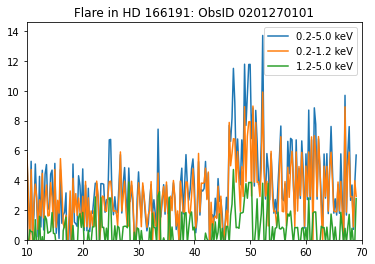

In [208]:
plt.plot(timebins[:-1] / 1000, filtered_lc_subtr(src, bkg, t0, timebins, (200, 5000), 100),label='0.2-5.0 keV')
plt.plot(timebins[:-1] / 1000, filtered_lc_subtr(src, bkg, t0, timebins, (200, 1200), 100),label='0.2-1.2 keV')
plt.plot(timebins[:-1] / 1000, filtered_lc_subtr(src, bkg, t0, timebins, (1200, 5000), 100),label='1.2-5.0 keV')

plt.legend()
plt.xlim(10, 70)
plt.ylim(0, None)
plt.title('Flare in HD 166191: ObsID 0201270101')

Text(0.5, 1.0, 'Lightcurve with Baysian blocks')

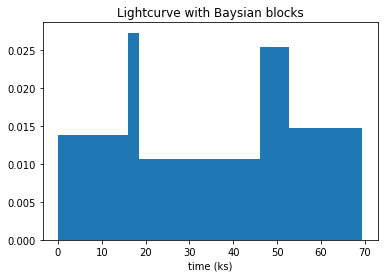

In [176]:
out = av.hist((src['TIME'] - t0)/1000, bins='blocks', density=True)
plt.xlabel('time (ks)')
plt.title('Lightcurve with Baysian blocks')

The two plot above show a lightcurve again. The higher one is a more traditional light curve with bins with a fixed bindwidth and zoomed in on the interesting bit. 

Again, there is indication for variability, but only on a level of a factor of 2 or so. The Baysian blocks binning (bottom plot) shows two flares, but only the latter one can be found in the traditional lightcurve as well. The quiecent count rate is similar to the ObsID I looked at above. The numerical value (best read-off from the Baysian-blocks diagram) is a little higher, but the source is also located a litle closer to the optical axis in this observation, so that's to be expected. (This is taken into account when I make the ARF for spectral fitting, thus I don't bother to work out exact numbers here.)

The count rate in the flare is so low though, that we can't see any spectral changes and I don't extract separate spectra for that phase. Yet, this lightcurve is further support for the observation that the source is in fact variable.

I may not have believed that, had I only looked at this data, but since we have the clear flare in the other lightcurve, I thin kthe most reasonable interpretation is that at least the latter of the two increases in count rate is real source variability.

## Spectral analsysis

is done in a separate document, because I'm using Sherpa for that and I don't have Sherpa installed in the same enviroment as SAS, so in this notebook, I just reduce the data and make the files and then I'll read them in and plot them in a separate document.